# PIVA-Finger detection

Antoni Jubés and Daniel Molinuevo

## General functions and data reading


In this section can be found all generic functions used during the following steps as well as the reading of the training and validation datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle as pkl

from tqdm import tqdm, notebook
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.color import rgb2yuv, yuv2rgb, rgb2hsv, hsv2rgb
from skimage import morphology
from scipy.stats import multivariate_normal, norm
from sklearn.metrics import f1_score, recall_score, precision_score, auc
from scipy.sparse import bsr_matrix, csc_matrix, lil_matrix
from scipy.ndimage.filters import gaussian_filter
from cv2 import watershed

# For the final notebook presentation ONLY
import warnings
warnings.filterwarnings('ignore')

''' Functions regarding data '''

def read_data(path, resizing = True, width = 256, height = 256):
    images = []
    targets = []
    fingers = []
    for image in os.listdir(path+'/Images/'):
        if not image[-3:] == 'jpg':
            continue
        
        im = imread(path+'/Images/'+image)
        if resizing:
            images.append(resize(im, (width, height)))
        else:
            images.append(im)
    
        target = image[:-3]+'bmp'
        im = (1-imread(path+'/Masks-Ideal/'+target)/255).astype(bool)
        if resizing:
            targets.append(resize(im, (width, height)))
        else:
            targets.append(im)

        fingers.append(int(image[0]))
    tr_images = np.array(images)
    target_np = np.array(targets)
    fingers_np = np.array(fingers)
    return tr_images, target_np, fingers


# Given a list of images, returns al list with all pixels
def get_pixels(images, targets = None, dim = 2, get_lengths = False):
    if targets is not None:
        pixels = images[0][targets[0] == 1].reshape(-1, dim)
    else:
        pixels = images[0].reshape(-1, dim)
    lengths = np.zeros(images.shape[0], dtype=np.int64)
    lengths[0] = images[0].shape[0]*images[0].shape[1]
    for i, image in enumerate(images):
        if i == 0:
          continue
        l = pixels.shape[0]
        if targets is not None:
            pixels = np.concatenate((pixels, image[targets[i] == 1].reshape(-1, dim)), axis = 0)
        else:
            pixels = np.concatenate((pixels, image.reshape(-1, dim)), axis = 0)
        lengths[i] = pixels.shape[0] - l
    if get_lengths:
        return pixels, lengths
    else:
        return pixels


''' Functions regarding chrominance and luminance '''

def plot_yuv(ima, lum = 0.5):
    ima_yuv = rgb2yuv(ima)
    plt.figure(None, (10, 5))
    ax1 = plt.subplot(1, 4, 1)
    ax1.imshow(ima_yuv[:,:,0], cmap = 'gray')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Y')

    ax2 = plt.subplot(1, 4, 2)
    ax2.imshow(ima_yuv[:, :, 1], cmap = 'Blues')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title('Cb')

    ax3 = plt.subplot(1, 4, 3)
    ax3.imshow(ima_yuv[:, :, 2], cmap = 'Reds')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title('Cr')

    ax4 = plt.subplot(1, 4, 4)
    crom = yuv2rgb(np.concatenate((lum*np.ones((ima_yuv.shape[0], ima_yuv.shape[1], 1)), ima_yuv[:,:,1:]), axis = 2))
    ax4.imshow(crom)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_title('Chrom with Y = ' + str(lum))

def to_yuv(images, keep_lum = True):
    images_yuv = []
    for image in images:
      image_yuv = rgb2yuv(image)
      if keep_lum:
        images_yuv.append(image_yuv)
      else:
        images_yuv.append(image_yuv[:, :, 1:])
    return(np.array(images_yuv))

def plot_hsv(ima, lum = 0.5):
    ima_hsv = rgb2hsv(ima)
    plt.figure(None, (10, 5))
    ax1 = plt.subplot(1, 4, 1)
    ax1.imshow(ima_hsv[:,:,2], cmap = 'gray')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Value')

    ax2 = plt.subplot(1, 4, 2)
    ax2.imshow(ima_hsv[:, :, 0], cmap = 'Blues')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title('Hue')

    ax3 = plt.subplot(1, 4, 3)
    ax3.imshow(ima_hsv[:, :, 1], cmap = 'Reds')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title('Saturation')

    ax4 = plt.subplot(1, 4, 4)
    crom = hsv2rgb(np.concatenate((lum*np.ones((ima_hsv.shape[0], ima_hsv.shape[1], 1)), ima_hsv[:,:,1:]), axis = 2))
    ax4.imshow(crom)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_title('Chrom with Value = ' + str(lum))

def to_hsv(images, keep_lum = True):
    images_hsv = []
    for image in images:
      image_hsv = rgb2hsv(image)
      if keep_lum:
        images_hsv.append(image_hsv)
      else:
        images_hsv.append(image_hsv[:, :, 1:])
    return(np.array(images_hsv))

''' Morphological transformations '''

def reconstruction_dilation(image, kernel_size = 3, binary = True):
    if not binary:
        dilated = morphology.dilation(image, selem = np.ones((kernel_size, kernel_size)))
    else:
        dilated = morphology.binary_dilation(image, selem = np.ones((kernel_size, kernel_size)))
    return morphology.reconstruction(dilated, image, method = 'erosion')

def reconstruction_erosion(image, kernel_size = 3, binary = True):
    if not binary:
        erosed = morphology.erosion(image, selem = np.ones((kernel_size, kernel_size)))
    else:
        erosed = morphology.binary_erosion(image, selem = np.ones((kernel_size, kernel_size)))
    return morphology.reconstruction(erosed, image, method = 'dilation')

def reconstruction_border(image, marker_shape = 'corners', method = 'erosion', connect8 = True):
    method = method.lower()
    assert(method in ['erosion', 'dilation'])
    assert(marker_shape in ['corners', 'border'])
    if method == 'dilation':
        marker = np.zeros(image.shape)
    else:
        marker = np.ones(image.shape)
    
    if marker_shape == 'corners':
        marker[0,0] = image[0,0]
        marker[0,-1] = image[0,-1]
        marker[-1,0] = image[-1,0]
        marker[-1,-1] = image[-1,-1]
    else:
        marker[0, :] = image[0,:]
        marker[:,-1] = image[:,-1]
        marker[-1,:] = image[-1,:]
        marker[:, 0] = image[:,0]

    selem = None
    if not connect8:
        selem = np.zeros((3,3))
        selem[1,:] = 1
        selem[:,1] = 1

    return morphology.reconstruction(marker, image, method = method, selem = selem)

def top_hat(image, dilation = True, binary = True):
    if binary:
        if dilation:
            dilated = morphology.binary_dilation(image)  
        else:
            dilated = morphology.binary_erosion(image)
    else:
        if dilation:
            dilated = morphology.dilation(image)  
        else:
            dilated = morphology.erosion(image)

    return np.abs(image-dilated)

def circle(radius, center = None, grid = None, ret_circle = False):
    if center is None or grid is None:
        center = np.array([radius-1,radius-1])
        grid = np.array([2*radius-1, 2*radius-1])
    x, y = np.indices((grid[0], grid[1]))
    x1 = center[0]
    y1 = center[1]
    r1 = radius
    mask_circle = (x - x1)**2 + (y - y1)**2 < r1**2
    image = mask_circle.astype(np.float64)
    if ret_circle:
        return image, mask_circle.astype(np.float64)
    else:
        return image

def elipsis(radius, center, grid, cov, ret_circle = False):
    if center is None or grid is None:
        center = np.array([radius-1,radius-1])
        grid = np.array([2*radius-1, 2*radius-1])
    vaps, rot = np.linalg.eig(cov)
    #vaps = np.log(vaps/np.min(vaps)+1)
    rad = np.ones(2)
    rad[np.argmax(vaps)] += np.log(np.max(vaps)/np.min(vaps))/10
    rad = radius*rad
    a = rad[0]
    b = rad[1]
    t = np.linspace(0, 2*np.pi, np.prod(grid))
    points = np.array([a*np.cos(t), b*np.sin(t)])
    points = rot@points
    points = np.repeat(center.reshape(-1,1), len(t), axis=1) + points
    pixels = np.round(points)

    pixels[0] = np.maximum(np.repeat(0,len(t)), np.minimum(np.repeat(grid[0]-1, len(t)), pixels[0]))
    pixels[1] = np.maximum(np.repeat(0,len(t)), np.minimum(np.repeat(grid[1]-1, len(t)), pixels[1]))

    image = np.zeros(grid)
    image[pixels[0].astype(int), pixels[1].astype(int)] = 1
    x, y = np.indices((grid[0], grid[1]))
    image2 = reconstruction_border(image, connect8=False)
    if ret_circle:
        return image2, image
    else:
        return image2


''' Evaluation metrics representation '''

def mean_precision(targets, predicts, lengths = None):
    if lengths is None:
        lengths = np.array([targets.shape[0]])
    encertats = targets*predicts
    total_images = len(lengths)
    mean_precision = 0
    cum_length = 0
    for i, length in enumerate(lengths):
        if np.sum(predicts[cum_length:cum_length+length]) == 0:
            mean_precision += 1
        else:
            mean_precision += np.sum(encertats[cum_length:cum_length+length])/np.sum(predicts[cum_length:cum_length+length])
        cum_length += length
    mean_precision /= total_images
    return mean_precision

def mean_recall(targets, predicts, lengths = None):
    if lengths is None:
        lengths = np.array([targets.shape[0]])
    encertats = targets*predicts
    total_images = len(lengths)
    mean_recall = 0
    cum_length = 0
    for i, length in enumerate(lengths):
        mean_recall += np.sum(encertats[cum_length:cum_length+length])/np.sum(targets[cum_length:cum_length+length])
        cum_length += length
    mean_recall /= total_images
    return mean_recall

def plot_roc(recall, precision, axis = None):
    if axis is None:
        axis = plt.gca()
    not_nan = np.argwhere(~ np.isnan(recall+precision))
    total_auc = auc(recall[not_nan], precision[not_nan])
    axis.plot(recall, precision, '.-b')
    axis.set_xlabel('Recall')
    axis.set_ylabel('Precision')
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.text(1.1, 0.9, f'AUC = {total_auc:.2f}', fontsize = 15)

def plot_f1(thresholds, recalls, precisions, axis = None, plt_format = None):
    f1_scores = 2*recalls*precisions/(recalls+precisions)
    if axis is None:
        axis = plt.gca()
    if plt_format is None:
        plt_format = '-b'

    axis.plot(thresholds, f1_scores, plt_format)
    axis.set_xlabel('Threshold')
    axis.set_ylabel('F1 Score')
    axis.set_ylim(0, 1)


''' Image graph functions '''
def get_adj_mat(image, all = False, connect8 = True):
    rows = image.shape[0]
    cols = image.shape[1]
    n = image.shape[0]*image.shape[1]   
    mat = lil_matrix((n, n))
    
    idx = np.arange(n)
    if not all:
        valid = image.reshape(-1).astype(int)
    else:
        valid = np.ones(n, dtype=np.int8)
    
    # Diagonal
    mat[idx, idx] = valid

    # 4-connectivity
    borders = np.ones(n)
    borders[rows-1::rows] = 0
    mat[idx[1:], idx[:-1]] = valid[1:]*valid[:-1]*borders[:-1]
    mat[idx[:-1], idx[1:]] = valid[:-1]*valid[1:]*borders[:-1]
    mat[idx[cols:], idx[:-cols]] = valid[cols:]*valid[:-cols]
    mat[idx[:-cols], idx[cols:]] = valid[:-cols]*valid[cols:]
    
    if connect8:
        # 8-connectivity
        mat[idx[(cols+1):], idx[:-(cols+1)]] = valid[(cols+1):]*valid[:-(cols+1)]*borders[:-(cols+1)]
        mat[idx[(cols):], idx[:-(cols)]] = valid[(cols):]*valid[:-(cols)]*borders[:-(cols)]
        mat[idx[:-(cols+1)], idx[(cols+1):]] = valid[:-(cols+1)]*valid[(cols+1):]*borders[:-(cols+1)]
        mat[idx[:-(cols)], idx[(cols):]] = valid[:-(cols)]*valid[(cols):]*borders[:-cols]
    return mat

def bfs(adj_mat, initial, max_level = 20):
    original_shape = initial.shape
    initial = initial.reshape(-1)
    # Levels is ans, not reached belong to level 0, we start from lvl 1
    levels = initial.copy()
    # To keep track of already reached nodes
    reached = initial.copy()
    level = 2
    while level == 2 or (new.any() and level < max_level):
        reached_new = adj_mat @ reached
        reached_new = (reached_new > 0).astype(int)
        new = (reached_new - reached).astype(bool)
        levels[new] = level
        level += 1
        reached = reached_new.copy()
    
    return levels.reshape(original_shape)



Let's first read the data:

In [ ]:
data_path = '/content/drive/My Drive/Finger detection/Data/'

train_images, train_targets, train_fingers = read_data(data_path+'Training-Dataset', False)
validation_images, validation_targets, validation_fingers = read_data(data_path+'Validation-Dataset', False)

We can see some examples

[]

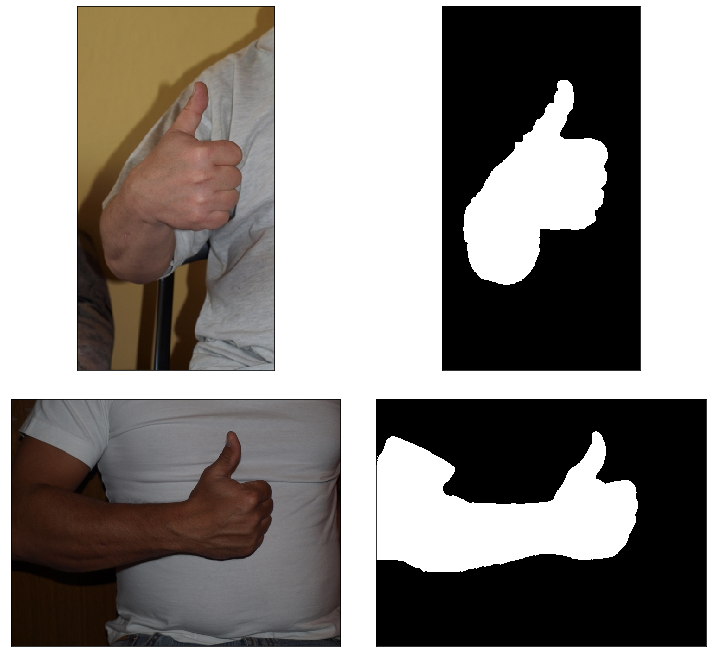

In [ ]:
plt.figure(None, (10, 10))
ax1 = plt.subplot(2, 2, 1)
imshow(train_images[0])
ax1.set_xticks([])
ax1.set_yticks([])
ax2 = plt.subplot(2, 2, 2)
ax2.set_xticks([])
ax2.set_yticks([])
imshow(train_targets[0])
ax3 = plt.subplot(2, 2, 3)
imshow(validation_images[1])
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = plt.subplot(2, 2, 4)
imshow(validation_targets[1])
ax4.set_xticks([])
ax4.set_yticks([])


## Skin detection

Let us start by comparing the chrominance values for skin a non skin pixels in three different examples:

Text(0.5, 1.0, 'Image 5')

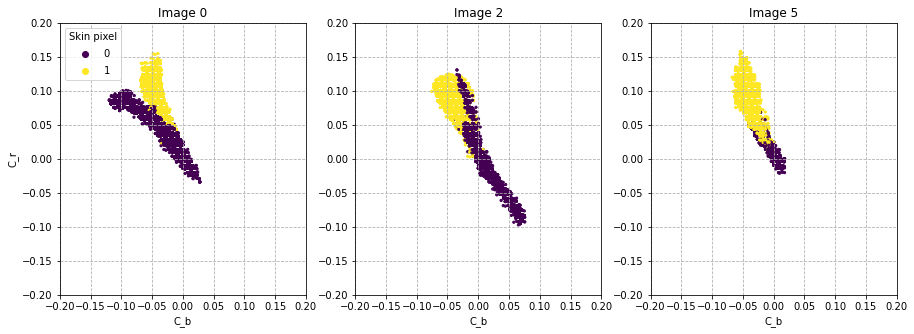

In [ ]:
plt.figure(None, (15, 5))
example = rgb2yuv(train_images[0])[:, :, 1:]
example_target = train_targets[0]

ax1 = plt.subplot(1, 3, 1)
scatter = plt.scatter(example[:, :, 0], example[:, :, 1], c = example_target[:, :], s = 5)
ax1.legend(*scatter.legend_elements(), loc="upper left", title = 'Skin pixel')
ax1.set_xlim(-0.2, 0.2)
ax1.set_ylim(-0.2, 0.2)
ax1.set_xlabel('C_b')
ax1.set_ylabel('C_r')
ax1.set_title('Image 0')
ax1.grid(True, axis = 'both', ls = '--')

example = rgb2yuv(train_images[2])[:, :, 1:]
example_target = train_targets[2]
ax2 = plt.subplot(1, 3, 2)
scatter = plt.scatter(example[:, :, 0], example[:, :, 1], c = example_target[:, :], s = 5)
ax2.set_xlim(-0.2, 0.2)
ax2.set_ylim(-0.2, 0.2)
ax2.set_xlabel('C_b')
ax2.set_title('Image 2')
ax2.grid(True, axis = 'both', ls = '--')

example = rgb2yuv(train_images[5])[:, :, 1:]
example_target = train_targets[5]
ax3 = plt.subplot(1, 3, 3)
scatter = plt.scatter(example[:, :, 0], example[:, :, 1], c = example_target[:, :], s = 5)
ax3.set_xlim(-0.2, 0.2)
ax3.set_ylim(-0.2, 0.2)
ax3.set_xlabel('C_b')
ax3.grid(True, axis = 'both', ls = '--')
ax3.set_title('Image 5')


It can be seen that in general, there quite a difference between the two classes, since we are able to easily distinguish to gropus. We also find some overlapping pixels (specially in the second one), which is inevitable.

Apart from this, we can observe that the yellow dots tend to move around the same zone in both cases, showing that the skin values seem to be quite invariant along different images.

Therefore, a first approach to discriminate the skin areas could be to use a pixel model taking into account the previous information. We could model the skin pixels as a multivariate gaussian and, given a pixel we want to classify, compute the p-value (cumulative distribution function) and use a threshold to decide whether it's skin or not.

In [ ]:
class gaussian_skin_detector:
    def __init__(self, mean = None, covar = None):
        self.mean = mean
        self.covar = covar
        self.maximum = None
        if mean is not None and covar is not None:
            self.maximum = multivariate_normal.pdf(self.mean, self.mean, self.covar)

    def fit_params(self, images, target, dim = 2):
        # Calculate mean and covar of all skin pixels
        total_sum = np.zeros(dim)
        covar_sum = np.zeros((dim, dim))
        total_pixels = 0
        for i, image in enumerate(images):
            pixels = image[target[i] == 1]
            total_pixels += np.sum(target[i])
            total_sum += np.sum(pixels, axis = 0)
            covar_sum += pixels.T @ pixels
        self.mean = total_sum/total_pixels
        self.covar = (covar_sum - np.outer(total_sum, total_sum)/(total_pixels))/(total_pixels-1)
        self.maximum = multivariate_normal.pdf(self.mean, self.mean, self.covar)


    def fit_params(self, images, target, dim = 2):
        total_sum = np.zeros(dim)
        covar_sum = np.zeros((dim, dim))
        total_pixels = 0
        for i, image in enumerate(images):
            targettemp = target[i].copy()
            pixelsx = image.transpose(2,0,1)[0]
            pixelsy = image.transpose(2,0,1)[1]
            targettemp[(pixelsy < 0.08)*(pixelsx > -0.025)*(0 > pixelsx)] = 0
            pixels = image[targettemp == 1]
            total_pixels += np.sum(targettemp)
            total_sum += np.sum(pixels, axis = 0)
            covar_sum += pixels.T @ pixels
        self.mean = total_sum/total_pixels
        self.covar = (covar_sum - np.outer(total_sum, total_sum)/(total_pixels))/(total_pixels-1)
        self.maximum = multivariate_normal.pdf(self.mean, self.mean, self.covar)

    def predict_single(self, image, binarize = True, threshold = 0.05, postprocess = False, kernel_size = 3, close_first = True, gaussian=True):
        quant = multivariate_normal.pdf(image, self.mean, self.covar)
        if gaussian:
            quant = gaussian_filter(quant, 1)
        if binarize:
            prediction = quant >= threshold*self.maximum
        else:
            prediction = quant/self.maximum
        if postprocess:
            prediction = self.postprocess(prediction, kernel_size = kernel_size)
        
        return prediction
    
    def predict(self, images, binarize = True, threshold = 0.05, postprocess = False, kernel_size = 3, close_first = True):
        predictions = []
        for image in images:
            pred = self.predict_single(image, binarize, threshold, postprocess, kernel_size, close_first)
            predictions.append(pred)
        return(np.array(predictions))

    # For al thresholds, compute recall and accuracy
    def roc(self, images = None, targets = None, preds = None, step = 0.05, thresholds = None, postprocess = False, kernel_size = 3, close_first = True, log = True):
        if thresholds is None:
          thresholds = np.arange(0.95, 0.1, -step)
          thresholds = np.concatenate((thresholds, 10**np.arange(-1, -3, -5*step))) # Canviar aixo que es basura
          thresholds = np.append(thresholds, 0)
        its = len(thresholds)
        recalls = np.zeros(its)
        precisions = np.zeros(its)
        if preds is None:
            preds = get_pixels(self.predict(images, binarize = False, postprocess = postprocess, kernel_size = kernel_size, close_first = close_first), dim = 1)
        else:
            preds = get_pixels(preds, dim = 1)
        targets = get_pixels(targets, dim = 1)
        for i, threshold in enumerate(thresholds):
            curr_preds = preds >= threshold
            recalls[i] = mean_recall(targets,curr_preds)
            precisions[i] = mean_precision(targets, curr_preds)
            f1_measure = 2*(precisions[i]*recalls[i]/(precisions[i]+recalls[i]))
            if log:
                print(f'Threshold = {threshold:.3f} Recall= {recalls[i]:.3f} Precision= {precisions[i]:.3f} F1-score= {f1_measure:.3f}')
        return recalls, precisions, thresholds
    # Same, but with mean accuracies and recallas
    def mean_roc(self, images = None, targets = None, preds = None, step = 0.05, thresholds = None, postprocess = False, kernel_size = 3, close_first = True, log = True):
        if thresholds is None:
          thresholds = np.arange(0.95, 0.1, -step)
          thresholds = np.concatenate((thresholds, 10**np.arange(-1, -3, -5*step))) # Canviar aixo que es basura
          thresholds = np.append(thresholds, 0)
        its = len(thresholds)
        recalls = np.zeros(its)
        precisions = np.zeros(its)
        if preds is None:
            preds, lengths = get_pixels(self.predict(images, binarize = False, postprocess = postprocess, kernel_size = kernel_size, close_first = close_first), dim = 1, get_lengths = True)
        else:
            preds, lengths = get_pixels(preds, dim=1, get_lengths = True)
        targets = get_pixels(targets, dim = 1)
        for i, threshold in enumerate(thresholds):
            curr_preds = preds >= threshold
            recalls[i] = mean_recall(targets, curr_preds, lengths)
            precisions[i] = mean_precision(targets, curr_preds, lengths)
            f1_measure = 2*(precisions[i]*recalls[i]/(precisions[i]+recalls[i]))
            if log:
                print(f'Threshold = {threshold:.3f} Recall= {recalls[i]:.3f} Precision= {precisions[i]:.3f} F1-score= {f1_measure:.3f}')
        return recalls, precisions, thresholds

    

    def postprocess_all(self, predictions, marker = 'border', kernel_size = 5):
        postprocessed = []
        for pred in predictions:
            postprocessed.append(self.postprocess(pred, kernel_size = kernel_size, marker = marker))
        return(np.array(postprocessed))

    def postprocess(self, prediction, marker = 'border', kernel_size = 5):
        first = reconstruction_border(prediction, marker, 'erosion')
        second =  morphology.opening(first, selem = np.ones((kernel_size, kernel_size)))
        return second

In [ ]:
yuv_train = to_yuv(train_images, False)
detector = gaussian_skin_detector()
detector.fit_params(yuv_train, train_targets)
train_preds = detector.predict(yuv_train)

Let's represent the gaussian's contrours as well as some pixels of some of the images (skin pixels in red):

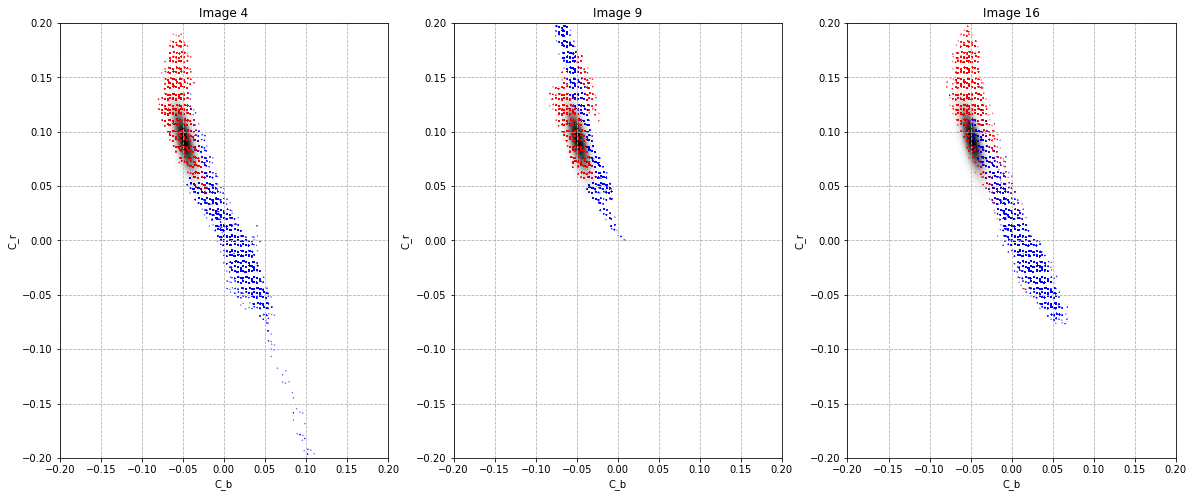

In [ ]:
# Define plot limits (based on gaussian)
factor = 5
xlims = [detector.mean[0]-factor*np.sqrt(detector.covar[0,0]), detector.mean[0]+factor*np.sqrt(detector.covar[0,0])]
ylims = [detector.mean[1]-factor*np.sqrt(detector.covar[1,1]), detector.mean[1]+factor*np.sqrt(detector.covar[1,1])]

xint = (xlims[1]-xlims[0])/100
yint = (ylims[1]-ylims[0])/100

color_map = np.array(['b', 'r'])

# Get gaussian values
x, y = np.mgrid[xlims[0]:xlims[1]:xint, ylims[0]:ylims[1]:yint]
pos = np.dstack((x, y))
rv = multivariate_normal(detector.mean, detector.covar)

# Examples to plot
examples = [4, 9, 16]
f = plt.figure(None, (20, 8))

for i, ex in enumerate(examples):
    ax1 = plt.subplot(1, len(examples), i+1)
    ax1.contourf(x, y, rv.pdf(pos), cmap = 'Greys', levels = 100)

    example = yuv_train[ex]
    example_target = train_targets[ex]

    scatter = plt.scatter(example[:, :, 0], example[:, :, 1], c = color_map[example_target[:, :].reshape(-1).astype(int)], s = 0.1)
    
    ax1.set_title('Image '+ str(examples[i]))
    ax1.set_xlabel('C_b')
    ax1.set_ylabel('C_r')
    ax1.set_xlim(-0.2, 0.2)
    ax1.set_ylim(-0.2, 0.2)
    ax1.grid(True, ls = '--')


In general, the gaussian seems a good approximation. It can be seen that in the first example there are some skin pixels that go up, but in some others they go down. Appart from this, when seeing some more examples, it seems that the mean should actually be displaced to the right, but if we take a closer look, we see that there is more density of points around where the mean is predicted to be.

In conclusion, the skin pixels distribution is not exactly a gaussian one, and has a bit of variation along some of the images. Despite this, it seems that if we use a low threshold value we can get quite good results from it (with a proper postprocessing).

Let's see some examples of how this system performs:

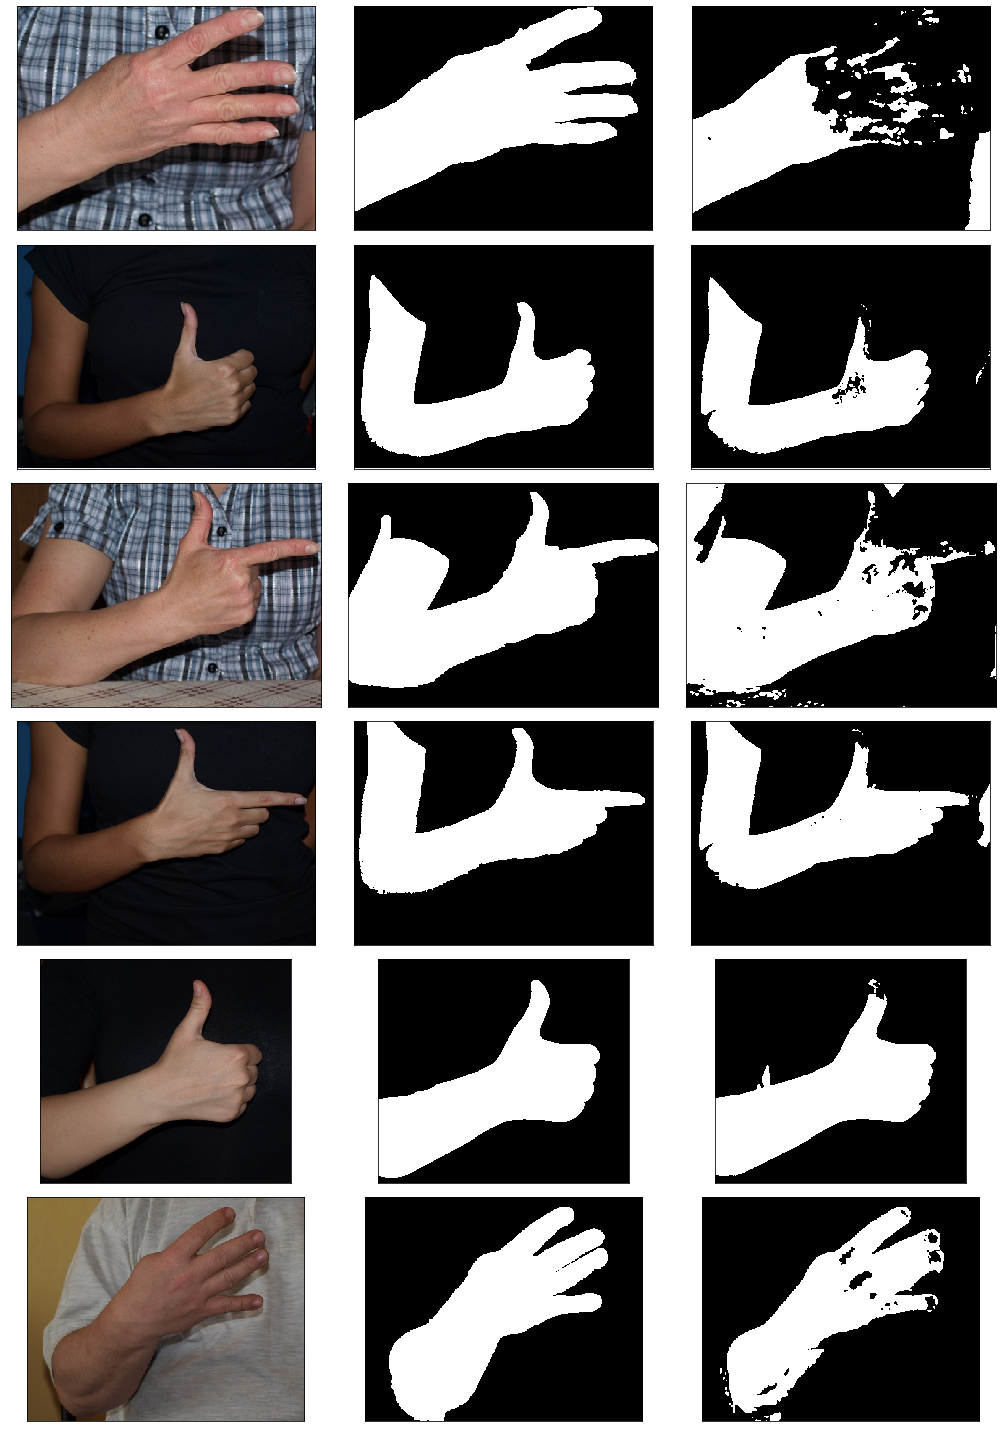

In [ ]:
f = plt.figure(None, (15, 20))
examples = [16, 2, 59, 15, 7, 58]
#examples = np.arange(10,20)
train_preds1 = detector.predict(yuv_train, threshold=0.1, postprocess=False)
for i, ex in enumerate(examples):
    ax1 = f.add_subplot(len(examples), 3, 3*i+1)
    imshow(train_images[ex])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2 = f.add_subplot(len(examples), 3, 3*i+2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    imshow(train_targets[ex])
    ax3 = f.add_subplot(len(examples), 3, 3*i+3)
    ax3.set_xticks([])
    ax3.set_yticks([])
    imshow(train_preds1[ex])


We can see that, since we are using a pixel level model, some inconsistent predictions can appear at the background, which do not make sense, since they are spontaneous pixels that do not seem to form a region.

Appart from this, we have som black pixels inside the hands, which are incosistent as well.

In order to remove both, at the beggining we decided to use an opening and a closing. This yielded decent results, but a pattern of errors appeared due to the closing: some fingers where being joined togethers. Appart from this, the results where quite good.

In order to avoid fingers being joined (this should be dealed with it at all costs, since at the end we want to count fingers), we used a closing by reconstuction using as marker image the border of the original image. This allowed us to reconstruct the hand (without the unconnected black dots inside it) and without joining fingers. 

We can see some examples here:

In [ ]:
train_preds = detector.predict(yuv_train, postprocess= False, threshold=0.15)
train_post = detector.predict(yuv_train, postprocess= True, threshold=0.15)

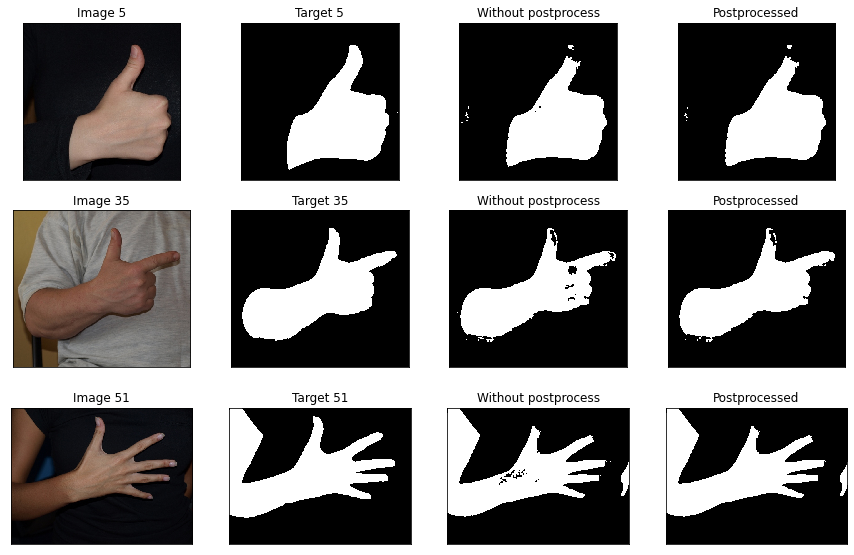

In [ ]:
f = plt.figure(None, (15, 8))
examples = [5, 35, 51]

for i, ex in enumerate(examples):
    ax1 = f.add_subplot(len(examples), 5, 5*i+1)
    imshow(train_images[ex])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Image '+ str(ex))

    ax2 = f.add_subplot(len(examples), 5, 5*i+2)
    imshow(train_targets[ex])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title('Target ' +str(ex))

    ax3 = f.add_subplot(len(examples), 5, 5*i+3)
    imshow(train_preds[ex])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title('Without postprocess')
    
    ax4 = f.add_subplot(len(examples), 5, 5*i+4)
    imshow(train_post[ex])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_title('Postprocessed')


It can be seen that black inconsistencies inside the hand have been eliminated with the postprocessing, as well as some outer white pixels. The problem is big exterior regions detected as skin, that cannot be removed.

### Hyperparameter optimization and evaluation

In order to evaluate the compare different results we will use two similar metrics:

+ F-score: We will compute the F-score with all pixels, not taking into account from which image comes each pixel.

+ Mean F-score: Since the above method may under-represent small images (we could be awfully predicting small images, but since they have less pixels the F-score won't be as affected as if the image where big). In order to solve this problem we propose to compute the F-score for each image and then average all of them.

Appart from this, we will test the robustness of the detection algorithm by means of ROC curves and AUC. At the end the hyperparameters will be chosen by the F-score, but having a look at the AUC will give us insightful information of the general robustness of our predictions.

Since the model is very simple (it only has 6 parameter to model pixels from 60 images), we decided to perform the hyperparameter on the training tes itself and see how it performs in the validation set (use it as test set). This is not the ideal, but we insist that the model is simple therefore it should not be overfitting the training set and, since the amount of data we have is limited we think this is a good approach.

For each possible (odd) kernel size we will try different thresholds and then plot the F-score and the mean F-score for each threshold. Using this information and, in case of doubt, the AUC we will choose a combination of threshold-kernel_size.

Done kernel size = 1.00, Best F1 = 0.912, Best mean F1 = 0.918
Done kernel size = 3.00, Best F1 = 0.912, Best mean F1 = 0.918
Done kernel size = 5.00, Best F1 = 0.912, Best mean F1 = 0.919
Done kernel size = 7.00, Best F1 = 0.912, Best mean F1 = 0.919
Done kernel size = 9.00, Best F1 = 0.912, Best mean F1 = 0.919
Done kernel size = 11.00, Best F1 = 0.912, Best mean F1 = 0.919


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:310: RuntimeWarning: invalid value encountered in true_divide


Done kernel size = 13.00, Best F1 = 0.912, Best mean F1 = 0.919
Done kernel size = 15.00, Best F1 = 0.912, Best mean F1 = 0.919
Best F1 combination: Kernel = 1.00, Threshold = 0.15
Best mean F1 combination: Kernel = 11.00, Threshold = 0.02


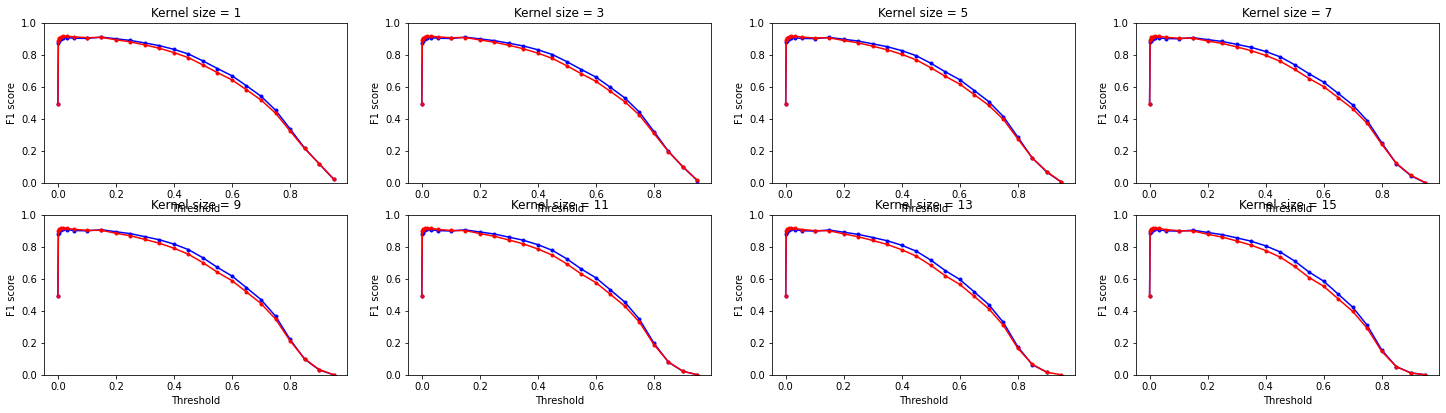

In [ ]:
sizes = [2*i+1 for i in range(0, 8)] # We try up to 17
preds = detector.predict(yuv_train, binarize = False, postprocess = False)

# In order to keep track of the best result:
best_f1 = 0
best_mf1 = 0
f1_pos = (0,0)
mf1_pos = (0,0)

f = plt.figure(None, (25, 10))
for i, kernel in enumerate(sizes):
    curr_preds = detector.postprocess_all(preds, kernel_size=kernel)
    #curr_preds = preds
    r, p, t = detector.roc(targets=train_targets, preds = curr_preds, log = False)
    f1 = 2*(r*p)/(r+p)
    curr_f1pos = np.argmax(f1)
    if f1[curr_f1pos] > best_f1:
        f1_pos = (kernel, t[curr_f1pos])
        best_f1 = f1[curr_f1pos]
    
    ax1 = f.add_subplot(3, 4, i+1)
    plot_f1(t, r, p, axis = ax1, plt_format = '.-b')

    r, p, t = detector.mean_roc(targets=train_targets, preds = curr_preds, log = False)
    f1 = 2*(r*p)/(r+p)
    curr_f1pos = np.argmax(f1)
    if f1[curr_f1pos] > best_mf1:
        mf1_pos = (kernel, t[curr_f1pos])
        best_mf1 = f1[curr_f1pos]
    plot_f1(t, r, p, axis = ax1, plt_format = '.-r')

    ax1.set_title('Kernel size = '+ str(kernel))
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('F1 score')

    print(f'Done kernel size = {kernel:.2f}, Best F1 = {best_f1:.3f}, Best mean F1 = {best_mf1:.3f}')
print(f'Best F1 combination: Kernel = {f1_pos[0]:.2f}, Threshold = {f1_pos[1]:.2f}')
print(f'Best mean F1 combination: Kernel = {mf1_pos[0]:.2f}, Threshold = {mf1_pos[1]:.2f}')

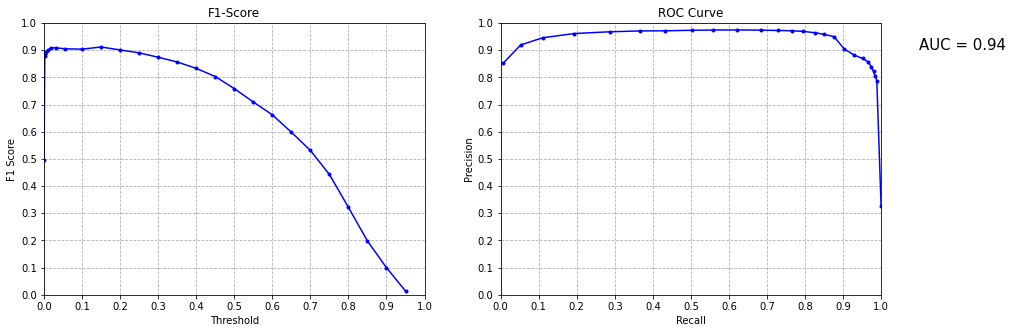

In [ ]:
f = plt.figure(None, (15, 5))
r, p, t = detector.roc(yuv_train, train_targets, log = False, postprocess = True)
ax = f.add_subplot(1, 2, 2)
plot_roc(r, p, ax)
ax.grid(True, ls = '--')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_title('ROC Curve')
ax = f.add_subplot(1, 2, 1)
plot_f1(t, r, p, ax, plt_format = '.-b')
ax.set_xlim(0, 1)
ax.grid(True, ls = '--')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_title('F1-Score')
a = None

Appart from this we checked the AUC and saw it is of order 0.94.
Seeing this, we decided to use the combination:
Now let's see how it performs in validation with this combination:

F1-Score = 0.913 Mean F1-Score = 0.921


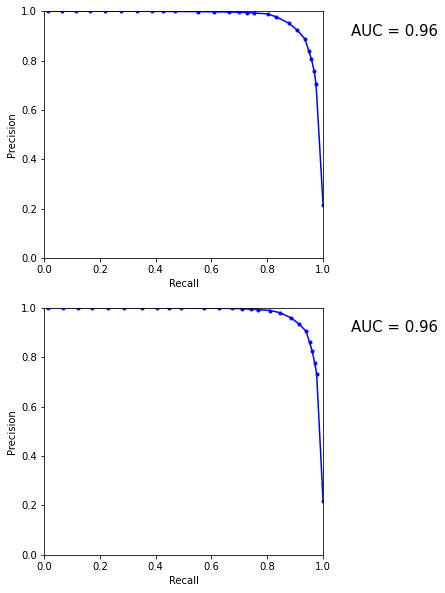

In [ ]:
best_threshold_idx = 18
best_kernel = 3
yuv_val = to_yuv(validation_images, keep_lum=False)
val_preds = detector.predict(yuv_val, threshold=best_threshold, postprocess=True, kernel_size = best_kernel)


f = plt.figure(None, (5, 10))
ax = f.add_subplot(2, 1, 1)
r, p, t = detector.roc(yuv_val, validation_targets, postprocess = True, kernel_size = best_kernel, log = False)
plot_roc(r, p, ax)

ax = f.add_subplot(2, 1, 2)
mr, mp, mt = detector.mean_roc(yuv_val, validation_targets, postprocess = True, kernel_size = best_kernel, log = False)
plot_roc(mr, mp, ax)
best_threshold = t[best_threshold_idx]
f1 = 2*r[t == best_threshold]*p[t == best_threshold]/(r[t == best_threshold]+p[t == best_threshold])
mf1 = 2*mr[mt == best_threshold]*mp[mt == best_threshold]/(mr[mt == best_threshold]+mp[mt == best_threshold])
print(f'F1-Score = {f1[0]:.3f} Mean F1-Score = {mf1[0]:.3f}')

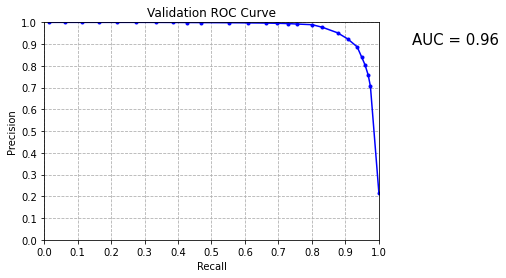

In [ ]:
f = plt.figure(None)
ax = plt.gca()
plot_roc(r, p, ax)
ax.grid(True, ls = '--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_title('Validation ROC Curve')
a = None

In [ ]:
# Run for phase 3
best_threshold = 0.15
best_kernel = 3

yuv_train = to_yuv(train_images, False)
yuv_val = to_yuv(validation_images, False)
detector = gaussian_skin_detector()
detector.fit_params(yuv_train, train_targets)
train_preds = detector.predict(yuv_train, threshold=best_threshold, postprocess=True, kernel_size=best_kernel)
val_preds = detector.predict(yuv_val, threshold=best_threshold, postprocess=True, kernel_size=best_kernel)

## Finger detection

In [ ]:
''' Performs bfs to find a candidate center of the hand '''
def get_hand_center(image, adjmat = None, levels = None, connect8=True, max_level = 1000):
    if adjmat is None:
        adjmat = get_adj_mat(image, connect8=connect8)
    # Get contour using a top hat
    border = top_hat(image, dilation = False)
    if levels is None:
      # Run bfs with contour as initial points
      levels = bfs(adjmat, border, max_level = max_level)
    
    # Get fardest points from border
    maxims = np.argwhere(levels == np.amax(levels))
    
    # Calculate the centroid
    maxims_center = np.mean(maxims, axis=0)
    center = np.round(maxims_center).astype(int)
    if maxims.shape[0] > 10:
        cov = np.cov(maxims.T)
    else:
        maxims = np.argwhere(levels == (np.amax(levels)-1))
        cov = np.cov(maxims.T)
    return center, cov, levels

''' Retrieves all connected points to marker '''
def get_region(image, marker):
    mark = np.zeros(image.shape)
    mark[marker[0], marker[1]] = 1
    region = morphology.reconstruction(mark, image, method = 'dilation')
    return region

''' Reconstructs the region from marker image '''
def get_region_area(image, mark):
    region = morphology.reconstruction(mark, image, method = 'dilation')
    return region


''' Retrieves all uncconected regions from an image'''
def get_regions(image):
    # To know what pixels have been labeled
    left_pixels = np.ones(image.shape)
    left_pixels[image == 0] = 0
    # Segmentation result
    labeled = np.zeros(image.shape, dtype = np.int8)
    # Get first non 0 pixel
    new_marker = np.unravel_index(np.argmax(left_pixels), image.shape)
    sizes = []
    curr_reg = 1
    while left_pixels.any():
        new_region = get_region(image, new_marker)
        left_pixels[new_region > 0] = 0
        labeled[new_region > 0] = curr_reg
        
        reg_size = np.sum(new_region)
        sizes.append(reg_size)
        curr_reg += 1
        new_marker = np.unravel_index(np.argmax(left_pixels), image.shape)
    
    return labeled, np.array(sizes)

''' Retrieves connecting lines from bfs result '''
def get_connecting_lines(levels, mask, kernel_size=3, dilation_radius = 2):
    # Use dilation to get local thresholds (local maxima)
    threshold = morphology.dilation(levels, selem = np.ones((kernel_size, kernel_size)))
    # Threshold bfs result to obtain the lines and set outer region to 0
    lines = (levels >= threshold).astype(int) * mask
    if dilation_radius is None:
        return lines
    selem = circle(dilation_radius)
    return morphology.binary_dilation(lines, selem = selem)

''' Implements step 7, retrieve regions connected to the ellipsis contour '''
def unmask_ellipse(center, cov, radius, levels):
    mask_ellipse = elipsis(radius, center, np.array(levels.shape), cov)
    # Get ellipse contour
    mark = morphology.binary_dilation(mask_ellipse, selem=np.ones((3,3))) - mask_ellipse
    # Initialize mark to image values on the contours
    mark = mark*levels
    result = np.zeros(levels.shape)
    # Get pixels outside ellipse
    result[mask_ellipse==0] = levels[mask_ellipse==0]
    # Retrieve regions from previous pixels
    connected = get_region_area(result, mark)
    return connected

''' Discards regions smaller than an arbitrary size '''
def filter_regions(labeled, reg_sizes, radius, min_size = 3):
    min_pixels = min_size*np.pi*radius**2
    valid = reg_sizes > min_pixels
    valid_sizes = reg_sizes[valid]
    i=1
    for reg in range(1, len(reg_sizes)+1):
        if not valid[reg-1]:
            labeled[labeled == reg] = 0
        else:
            labeled[labeled == reg] = i
            i += 1
    return labeled, valid_sizes

''' Returns closes non-0 point to an arbitrary marker '''
def get_closest_point(marker, labels, reg_sizes):
    # Construct marker image
    img_marker = np.zeros(labels.shape)
    img_marker[marker[0].astype(int),marker[1].astype(int)] = 1
    
    # Dilate marker image until intersects with some non-0 point(s)
    while not (img_marker*labels > 0).any():
        img_marker = morphology.binary_dilation(img_marker, selem = np.ones((3, 3)))
    
    # Get points that intersected (keep the one belonging to the biggest region)
    valid = img_marker*labels > 0
    closest_regs = np.unique(labels[valid])
    closest_size = np.max(reg_sizes[closest_regs-1])
    closest_reg = np.where(reg_sizes == closest_size)[0] + 1 # +1 due to the background region
    cpoints = np.array(np.where((valid) & (labels==closest_reg))).T
    cpoints = cpoints.reshape(-1)
    return cpoints[:2].astype(int)

''' Implements the whole processing pipeline '''
def predict_fingers(mask, levels=None, connect8 = False, dilation_kernel = 3, dilation_radius = 2,  min_filter_size = 3, elipse_radius = 1.2, outer_elipse_radius = 2, get_segmentation = False, show_steps = False):
    # Step 1: Calculate distances to closest border using bfs
    adjmat = get_adj_mat(mask, connect8 = connect8)
    center, cov, levels = get_hand_center(mask, adjmat = adjmat, connect8 = connect8, levels=levels)
    if show_steps:
        f = plt.figure(None, (15, 5))
        ax = f.add_subplot(1, 6, 1)
        ax.imshow(levels)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Step 1: Border distances')

    # Step 2: Reconstruct hand
    mask_clean = get_region(mask, center)
    levels_clean = mask_clean*levels
    if show_steps:
        ax = f.add_subplot(1, 6, 2)
        imshow(mask_clean)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Step 2: Hand region')
    
    # Step 3: Get connecting lines from bfs result and widden
    split_image = get_connecting_lines(levels_clean, mask_clean, kernel_size = dilation_kernel, dilation_radius = dilation_radius)
    if show_steps:
        ax = f.add_subplot(1, 6, 3)
        imshow(split_image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Step 3: Splitted hand')
    
    # Step 4: Retrieve unconnected regions
    labeled, reg_sizes = get_regions(split_image)
    if show_steps:
        ax = f.add_subplot(1, 6, 4)
        ax.imshow(labeled)
        ax.scatter(center[1],center[0],s = 20)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Step 4: Finger Segmentation')    
        '''
        print('Found regions: ')
        for i in range(len(reg_sizes)):
            print('Region '+ str(i) +': '+str(reg_sizes[i]))
        '''

    # Step 5: Filter small regions
    filt_labs, filt_sizes = filter_regions(labeled, reg_sizes, dilation_radius, min_size = min_filter_size)
    mean_center = np.round(np.mean(np.argwhere(filt_labs > 0), axis = 0)).astype(int)
    num_fingers = len(filt_sizes)-1
    _, elipse_contour = elipsis(elipse_radius*levels[center[0],center[1]], center, labeled.shape, cov, ret_circle=True)
    ellipse, big_elipse_contour = elipsis(outer_elipse_radius*levels[center[0],center[1]], center, labeled.shape, cov, ret_circle=True)
    if show_steps:
        ax = f.add_subplot(1, 6, 5)
        filt_labs2 = filt_labs.copy()
        filt_labs2[elipse_contour.astype(bool)] = 10
        filt_labs2[big_elipse_contour.astype(bool)] = 11
        ax.imshow(filt_labs2)
        ax.scatter(mean_center[1],mean_center[0], s=20,c='g')
        ax.scatter(center[1],center[0], s=20,c='r')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Step 5: Region filtering')
        '''
        print('Regions after filtering: ')
        for i, size in enumerate(filt_sizes):
            print('Region '+ str(i) +': '+str(size))
        '''
    # Step 6: Check hand center position
    mean_center = np.round(np.mean(np.argwhere(filt_labs > 0), axis = 0)).astype(int)
    if ellipse[mean_center[0], mean_center[1]] == 0:
        center = mean_center
        cpoint = get_closest_point(center, filt_labs, filt_sizes)
        center = cpoint.astype(int)
        cov = np.cov(np.argwhere(filt_labs == filt_labs[center[0],center[1]]).T)

    # Step 7: Get connected components to ellipse
    uncircled = unmask_ellipse(center, cov, elipse_radius*levels[center[0], center[1]], filt_labs)
    uncircled_bin = (uncircled > 0).astype(int)
    labeled_fin, reg_sizes_fin = get_regions(uncircled_bin)
    if show_steps:
        ax = f.add_subplot(1, 6, 6)
        imshow(labeled_fin)
        ax.scatter(center[1],center[0], s=20,c='r')
        ax.set_xticks([])
        ax.set_yticks([])
        try:
          ax.images[0].colorbar.remove()
        except:
          print('There´s nothing to plot :(')
        ax.set_title('Step 7: Uncircled Hand')
        '''
        for i, x in enumerate(reg_sizes_fin):
            print('Region '+ str(i) +': '+str(x))
        '''
    num_fingers = len(reg_sizes_fin)
    if get_segmentation:
        return num_fingers, labeled_fin
    return num_fingers

''' Predict all images from masks and bfs results '''
def predict_all(images, levels_all, **kwargs):
    preds = []
    for i, image in enumerate(images):
        preds.append(predict_fingers(image, levels_all[i], **kwargs))
    
    return preds

''' F1 implementation, slightly faster than f1_score '''
def f1_fingers(preds, targets, mean = True):
    f1 = np.zeros(len(np.unique(targets)))
    for j, i in enumerate(np.unique(targets)):
        correct = np.sum(preds[targets==i]==i)
        prec = correct/np.sum(preds==i)
        rec = correct/np.sum(targets==i)
        f1[j] = 2*(prec*rec)/(prec+rec)
    if mean:
        return np.mean(f1)
    return f1

In [ ]:
# Precompute all bfs
levels_all = []
for i, image in enumerate(train_preds):
    _,_, levels_temp = get_hand_center(image, connect8=False)
    levels_all.append(levels_temp)

levels_all_val = []
for i, image in enumerate(val_preds):
    _,_, levels_temp = get_hand_center(image, connect8=False)
    levels_all_val.append(levels_temp)

with open('/content/drive/My Drive/Finger detection/levels.p', 'wb') as f:
    pkl.dump(levels_all, f)
with open('/content/drive/My Drive/Finger detection/levels_val.p', 'wb') as f:
    pkl.dump(levels_all_val, f)

In [ ]:
# Read bfs
levels_all = pkl.load(open('/content/drive/My Drive/Finger detection/levels.p', 'rb'))
levels_all_val = pkl.load(open('/content/drive/My Drive/Finger detection/levels_val.p', 'rb'))

In [ ]:
# Best hyperparameters found in the corresponding section
Radius = 6
Filter = 7
Factor = 1.25

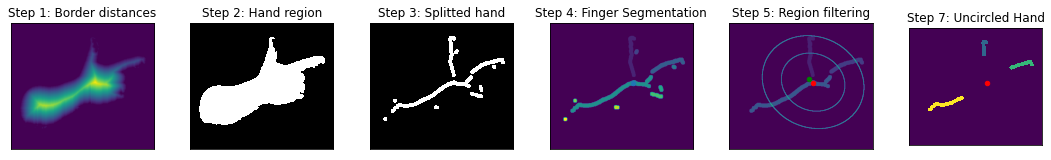

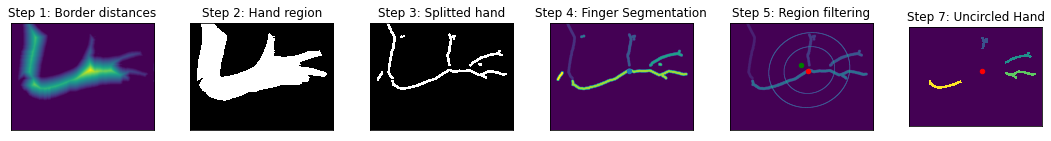

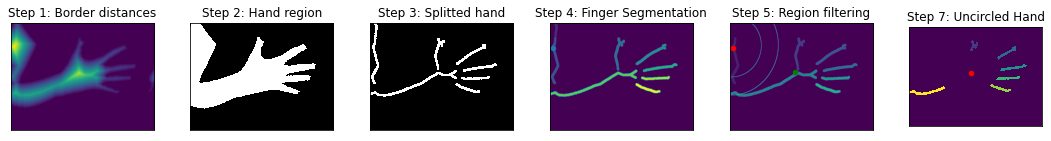

In [ ]:
# Cell to plot examples

idxs = [35, 45, 51]

for idx in idxs:
    example = train_preds[idx]
    a, labeled = predict_fingers(example, levels = levels_all[idx], get_segmentation=True, show_steps=True, dilation_radius = Radius,  min_filter_size = Filter, elipse_radius = Factor)

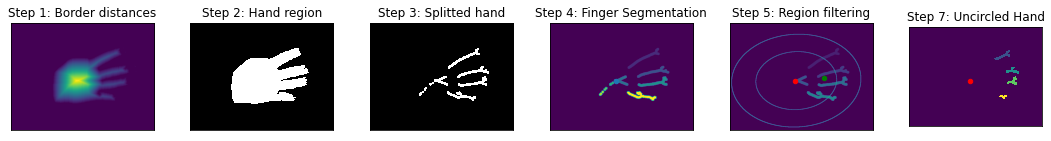

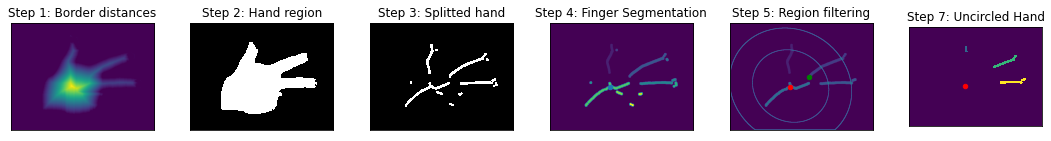

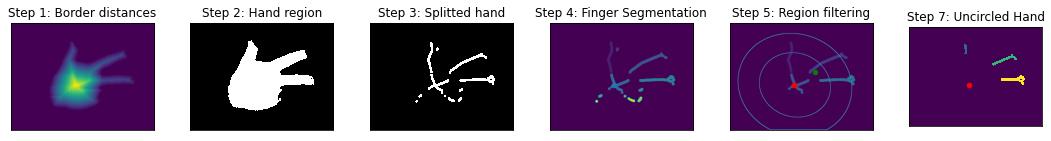

In [ ]:
# Cell to plot examples
idxs = [44, 11, 30]

for idx in idxs:
    example = val_preds[idx]
    a, labeled = predict_fingers(example, levels = levels_all_val[idx], get_segmentation=True, show_steps=True, dilation_radius = Radius,  min_filter_size = Filter, elipse_radius = Factor)

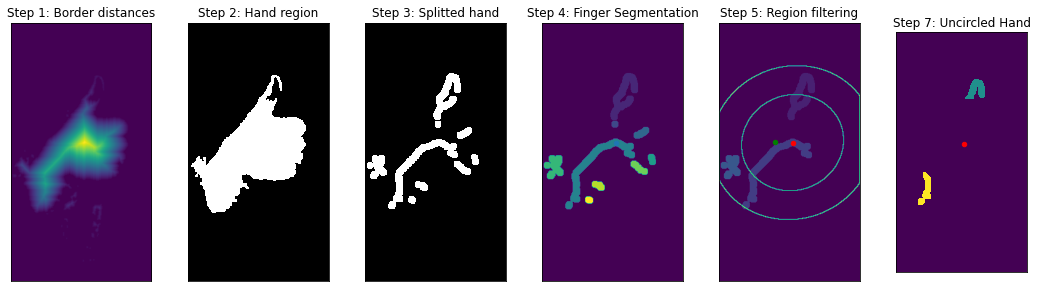

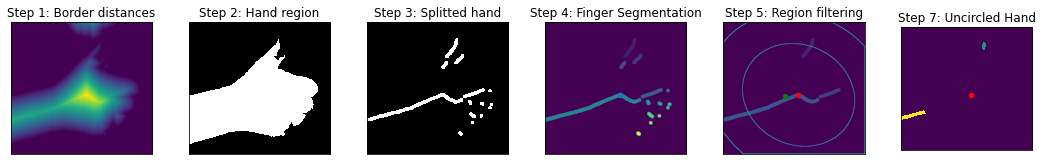

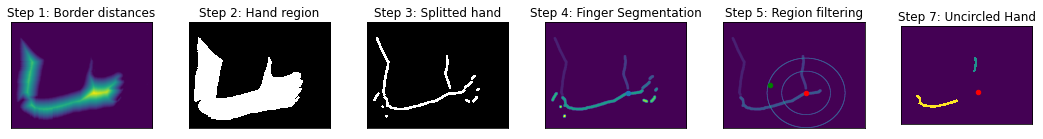

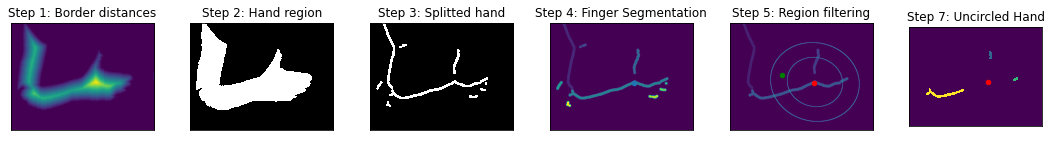

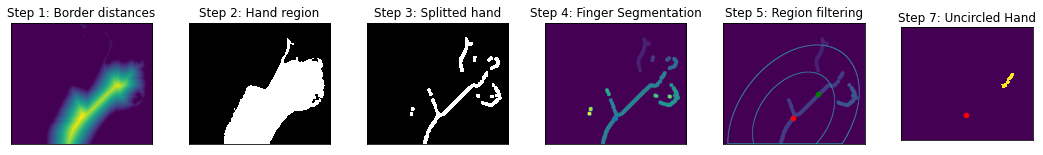

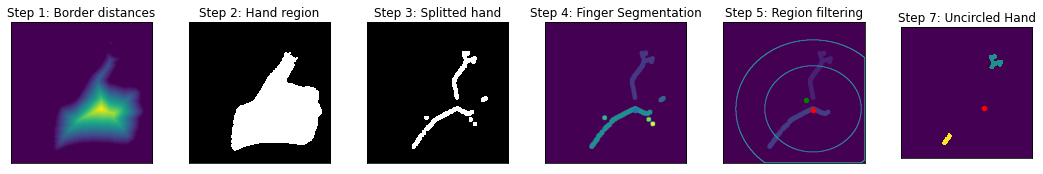

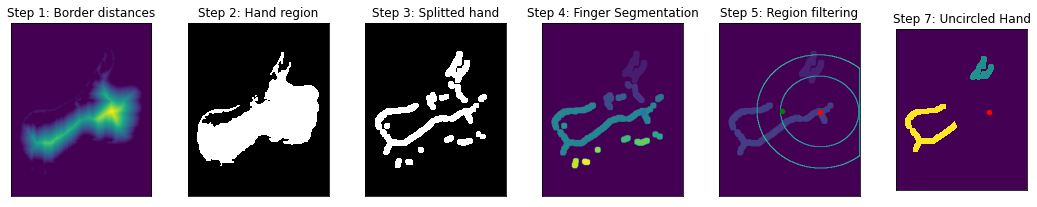

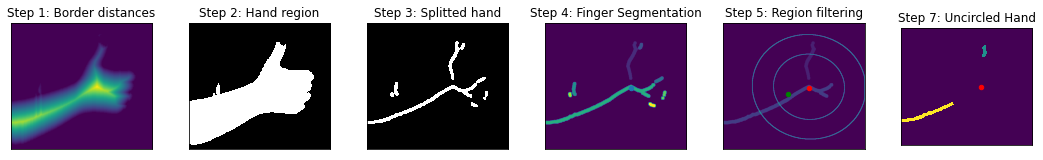

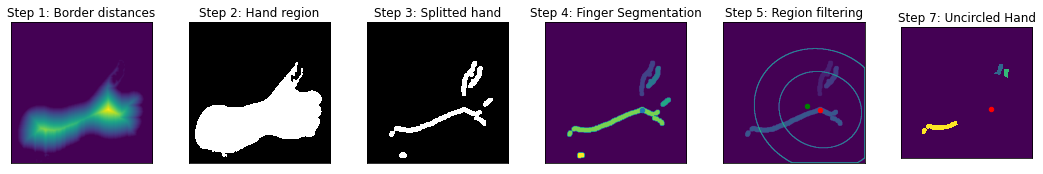

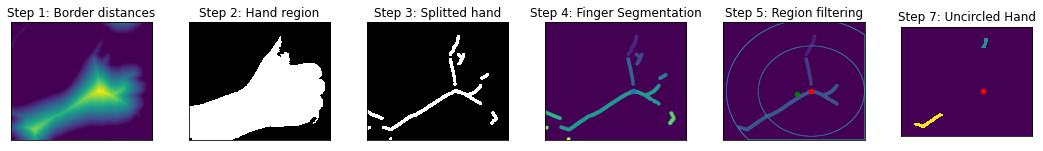

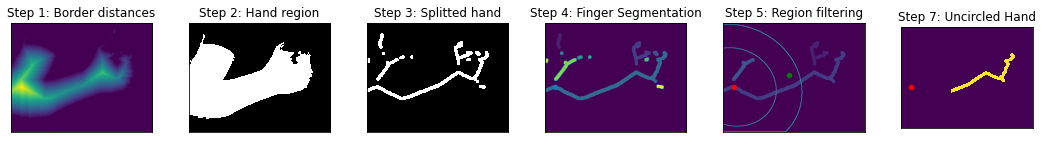

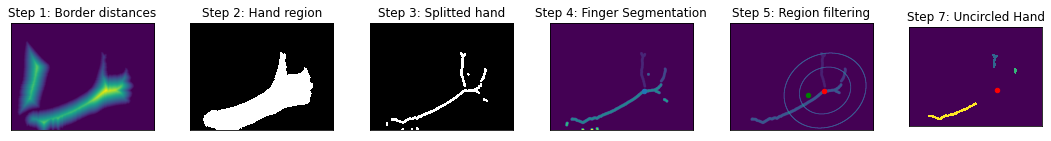

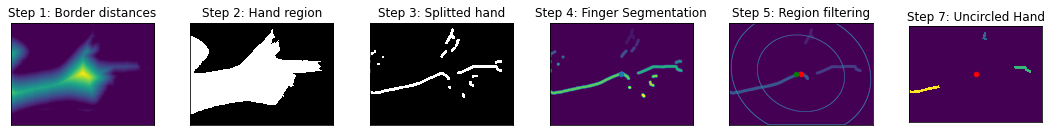

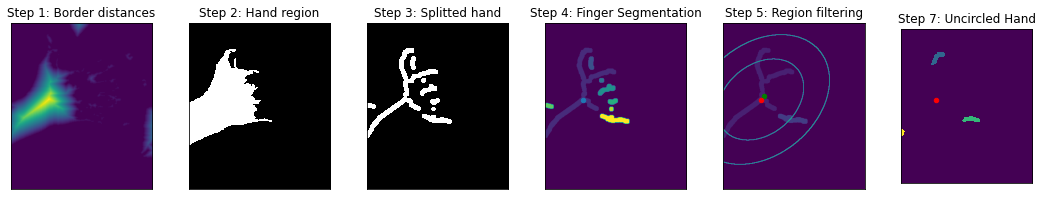

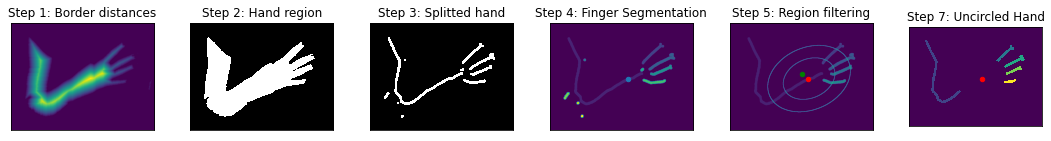

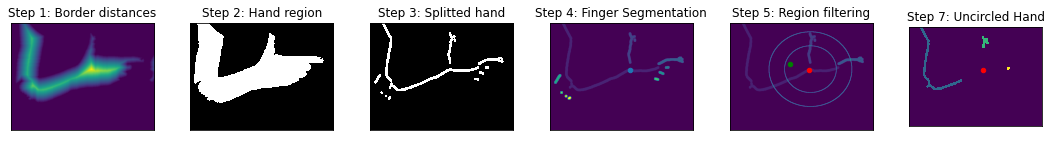

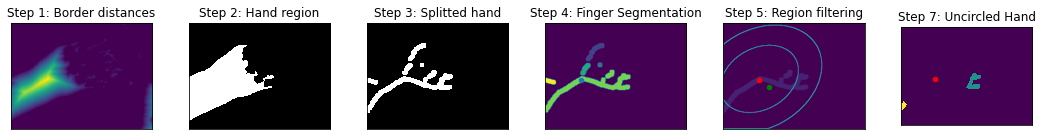

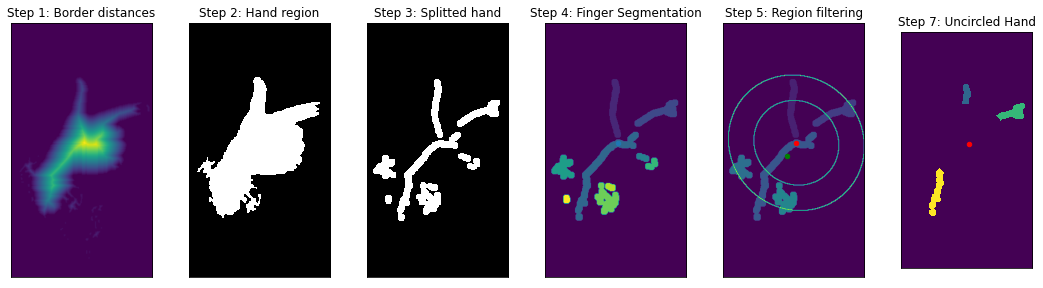

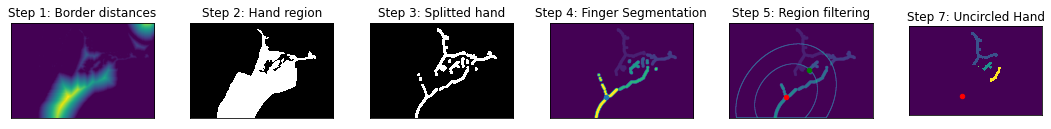

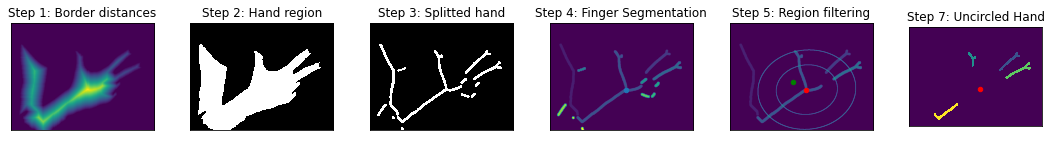

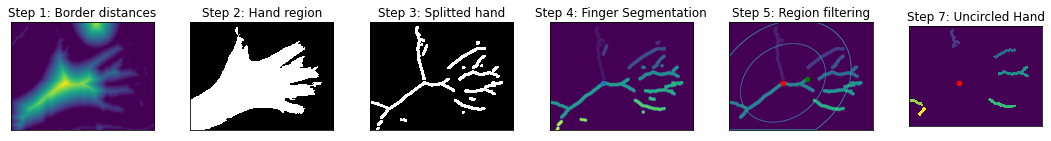

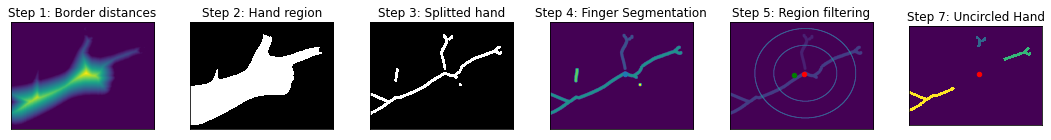

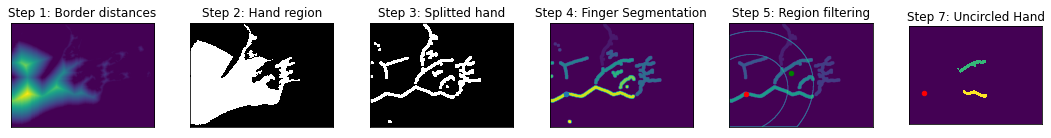

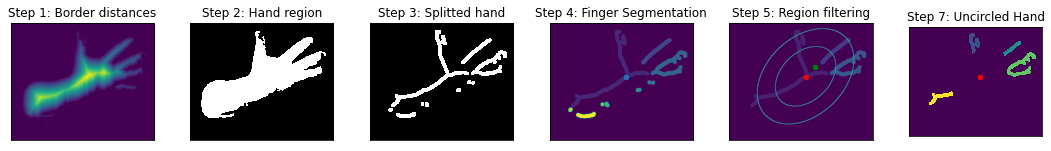

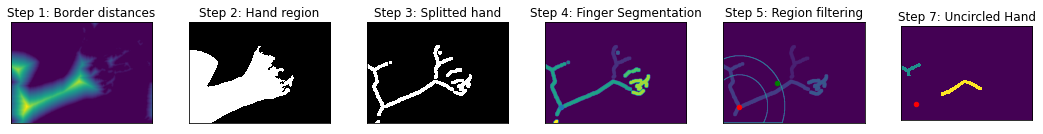

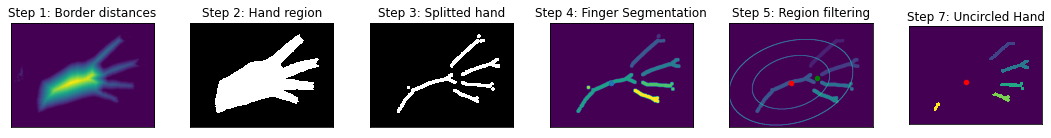

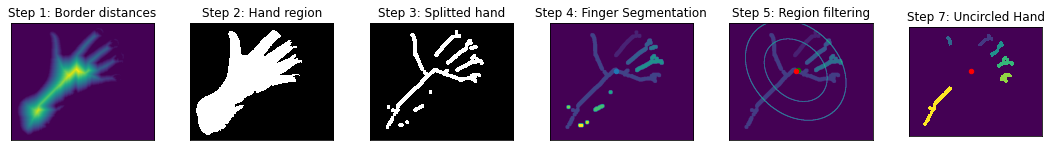

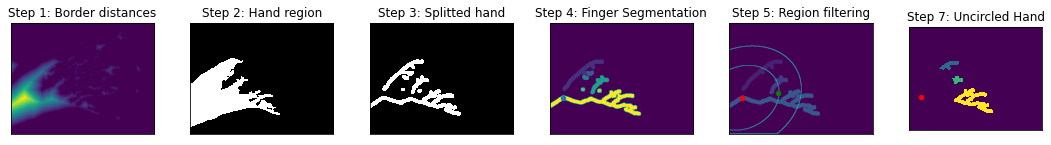

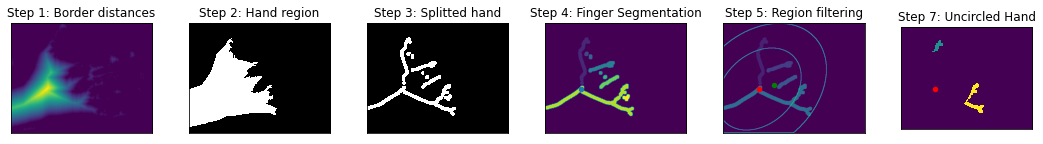

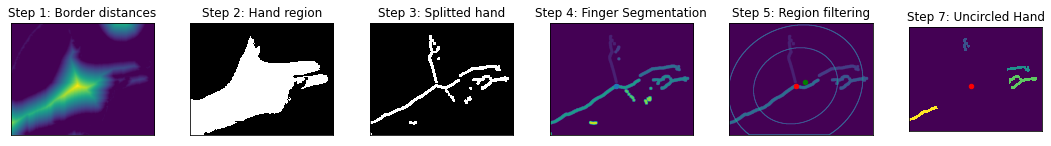

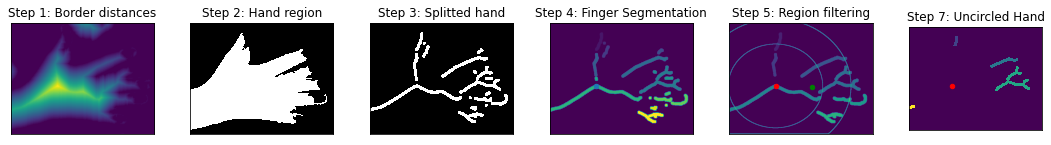

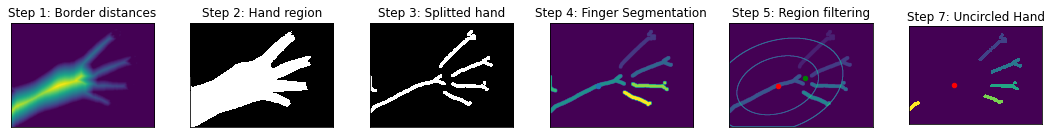

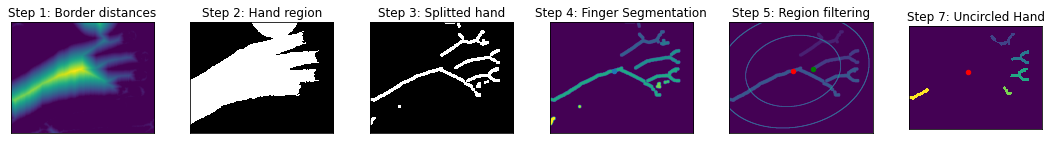

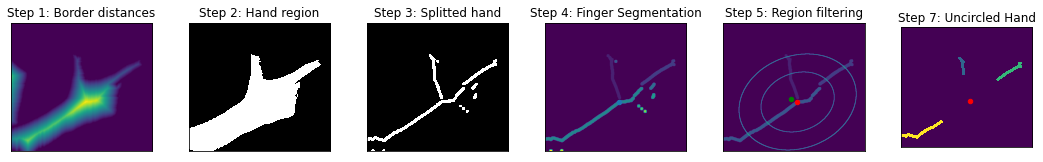

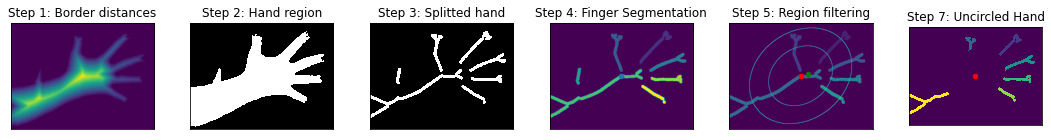

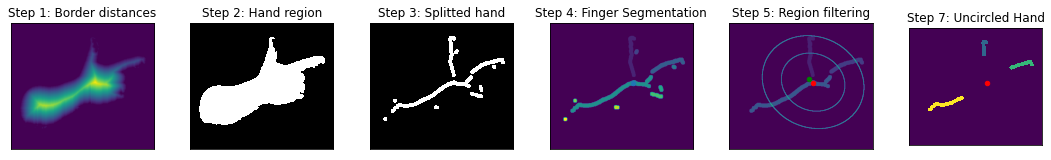

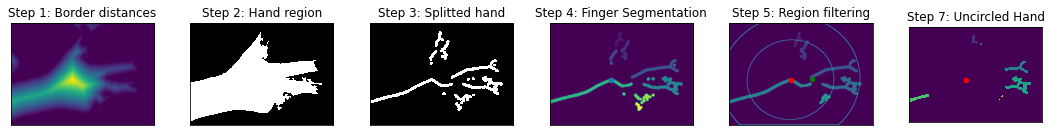

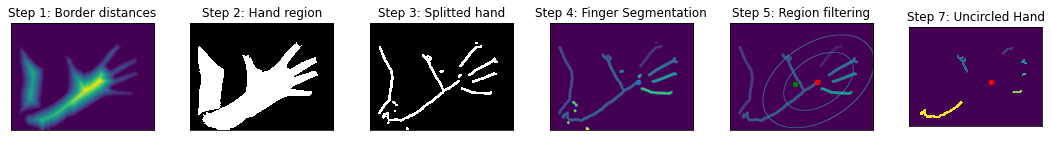

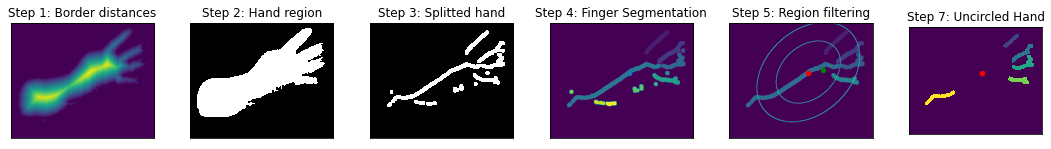

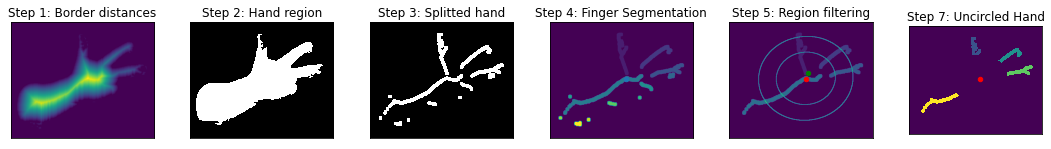

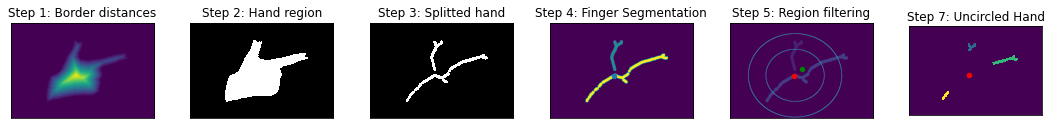

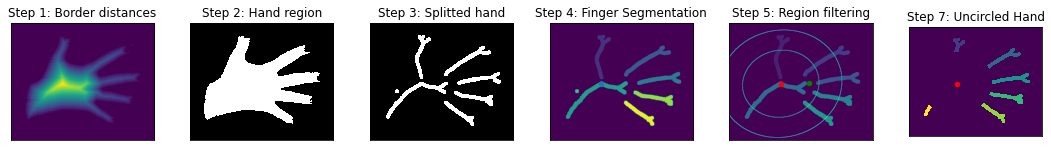

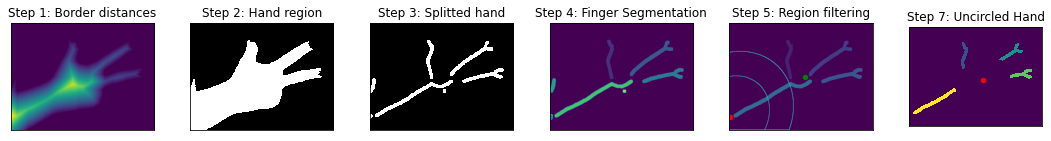

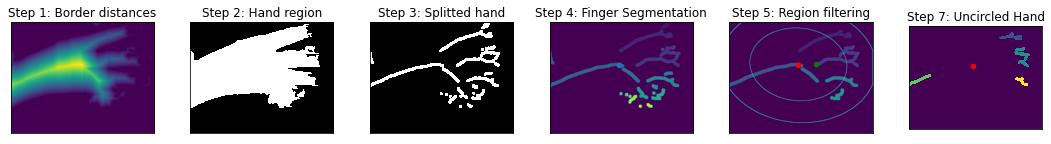

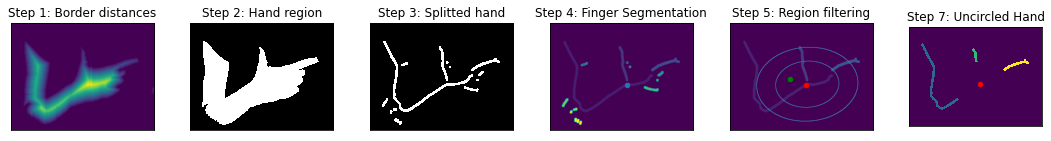

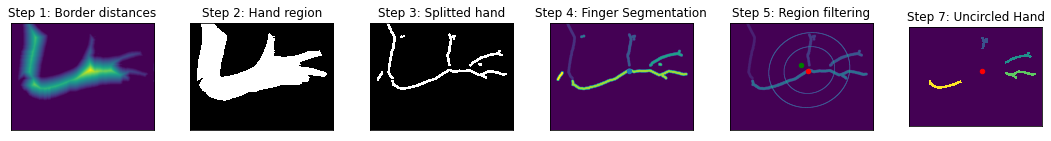

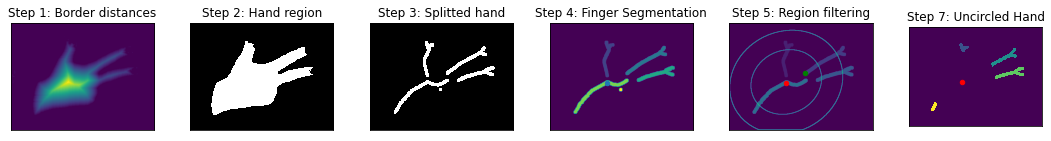

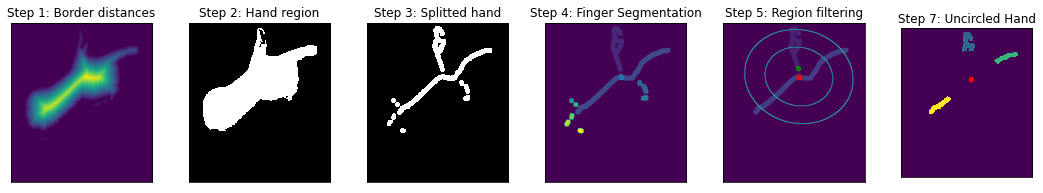

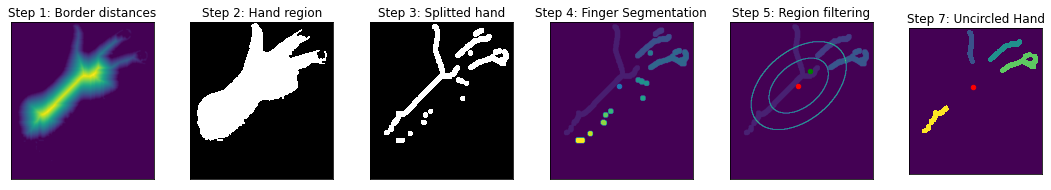

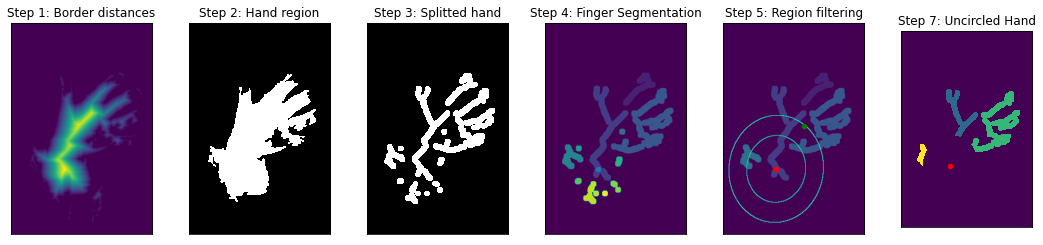

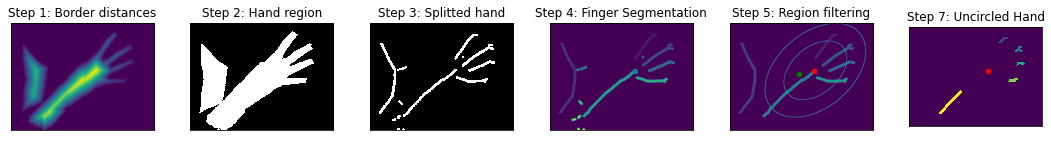

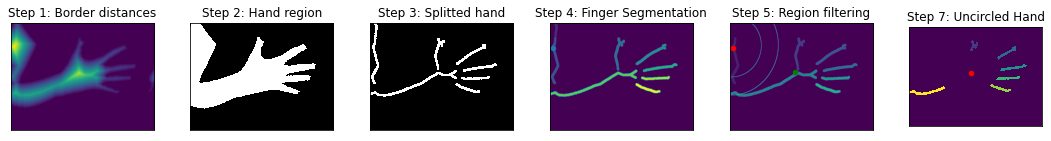

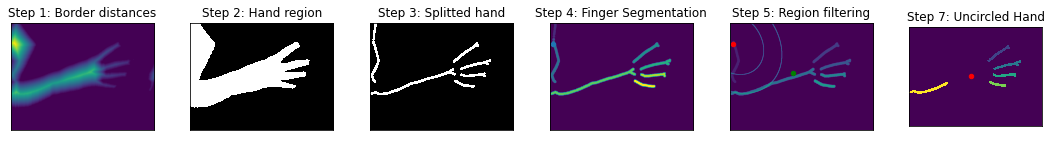

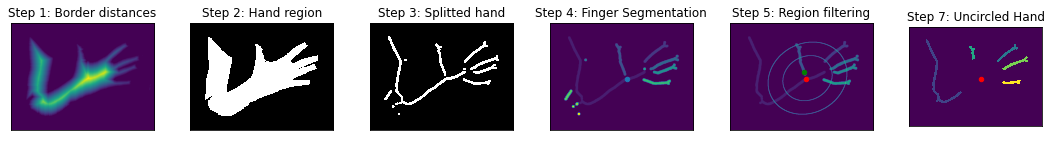

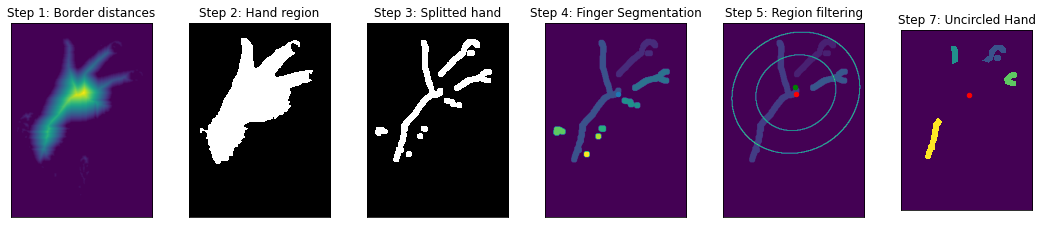

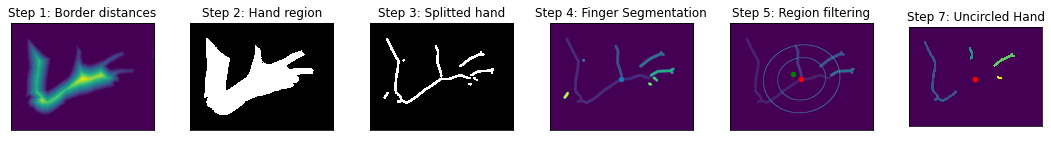

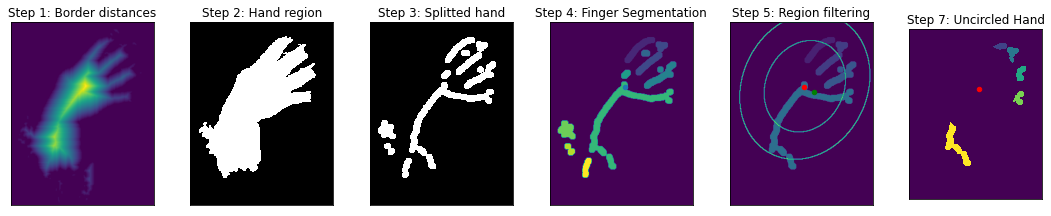

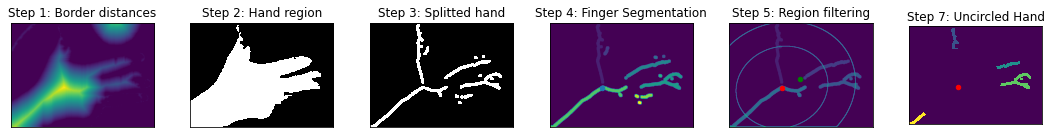

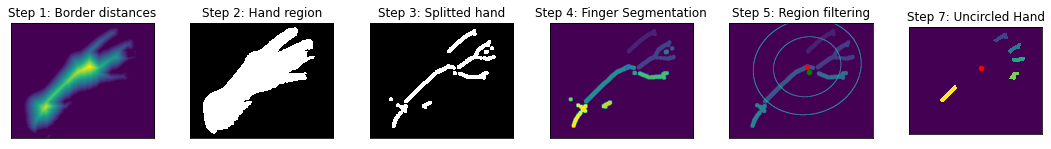

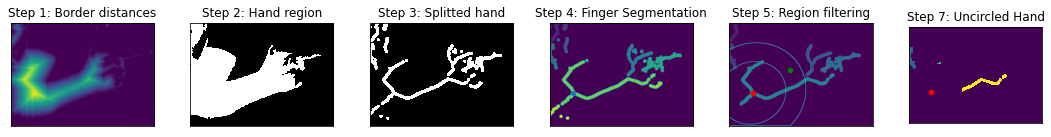

In [ ]:
# ALL train examples
preds = predict_all(train_preds, levels_all, get_segmentation=False, show_steps=True, dilation_radius = Radius, min_filter_size=Filter, elipse_radius=Factor)

In [ ]:
s = (np.maximum(np.minimum(np.repeat(5,len(preds)),np.array(preds)-1), np.ones(len(preds))))
np.sum(s==train_fingers)/len(s), f1_fingers(np.array(train_fingers),s)

(0.7166666666666667, 0.7147685630868775)

The results in the test/validation set are (it can be seen the general error done in the arm assumption):

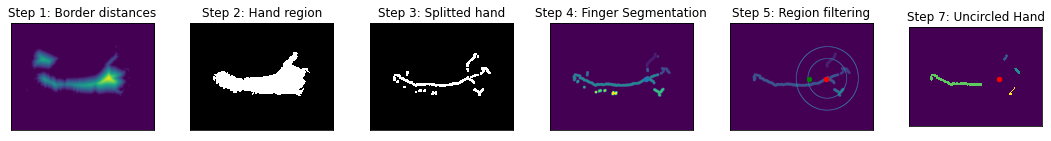

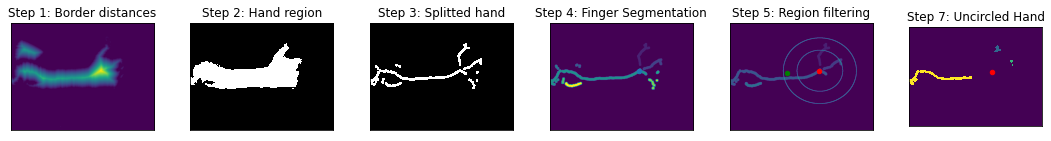

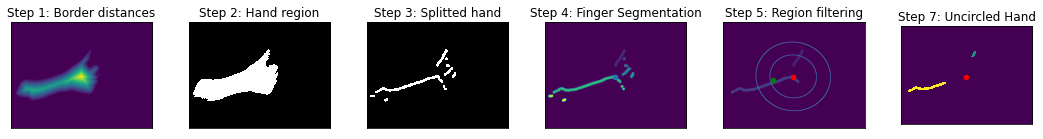

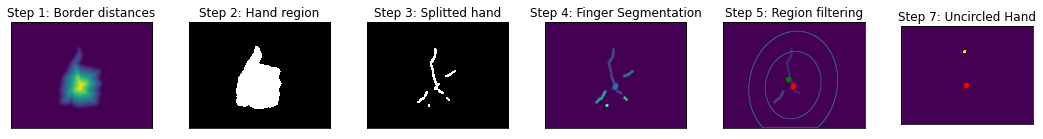

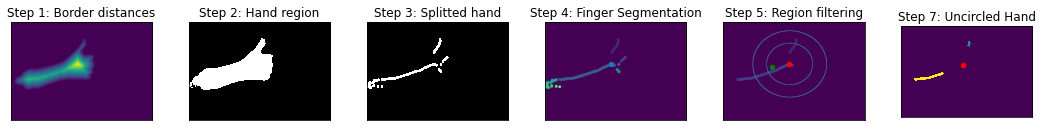

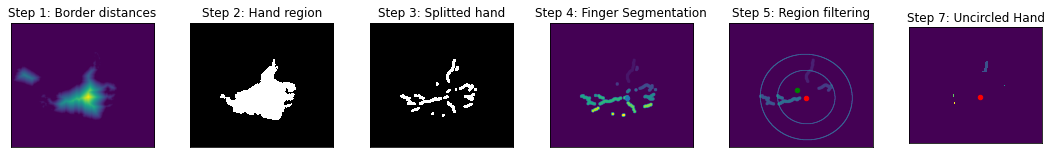

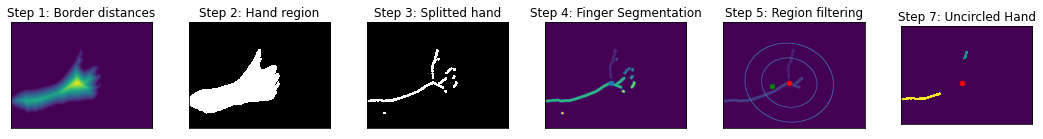

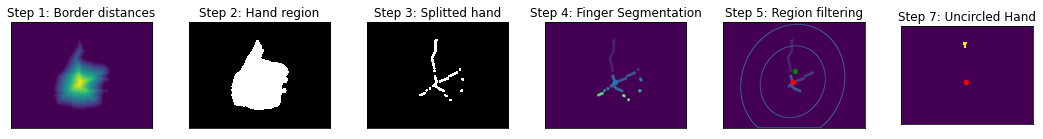

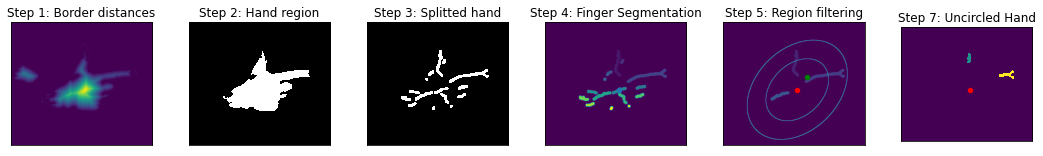

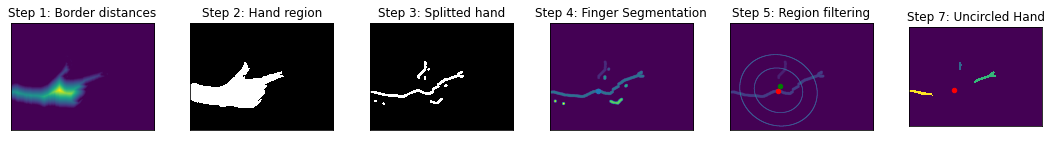

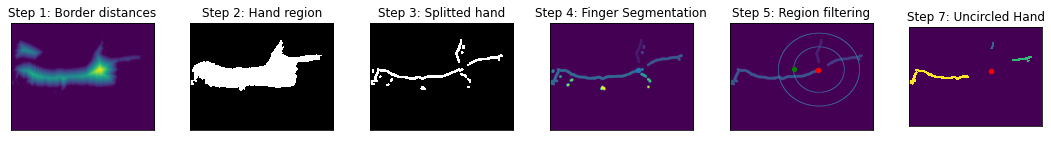

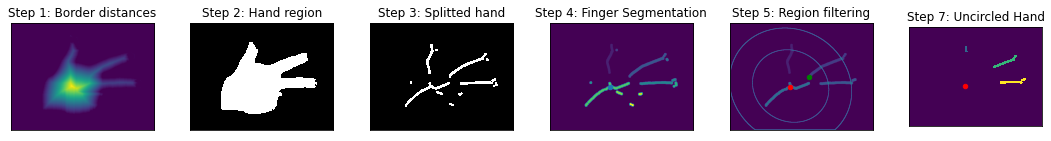

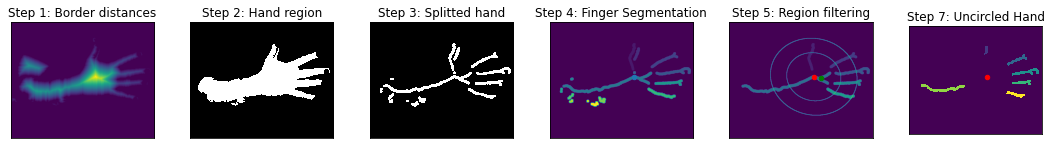

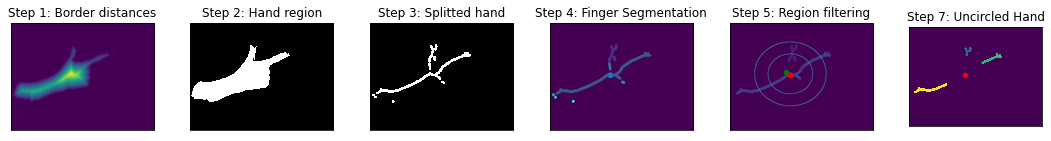

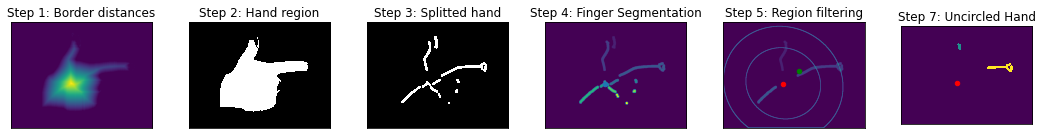

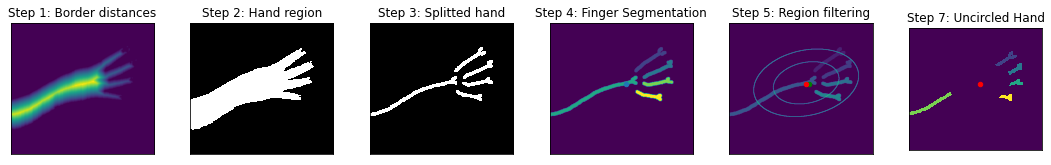

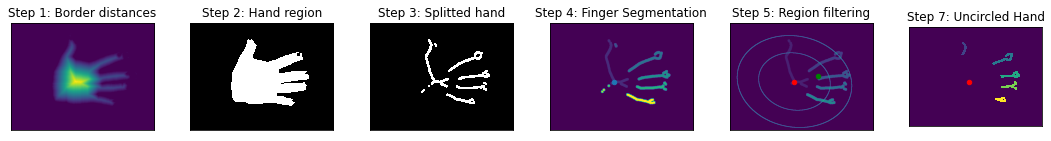

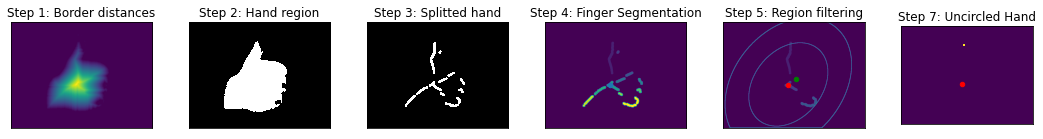

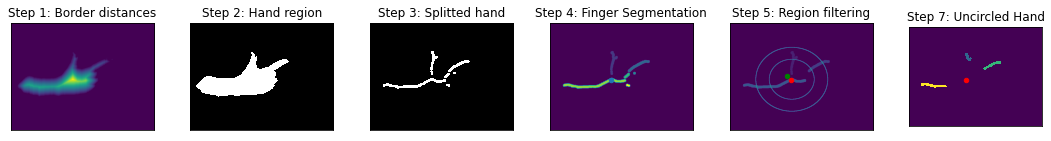

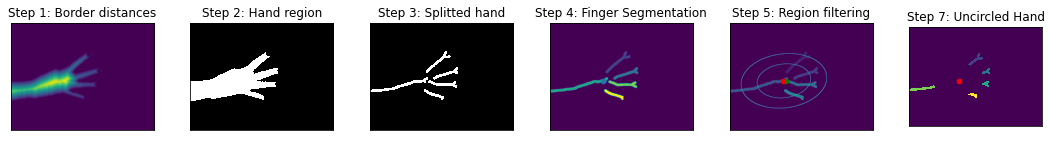

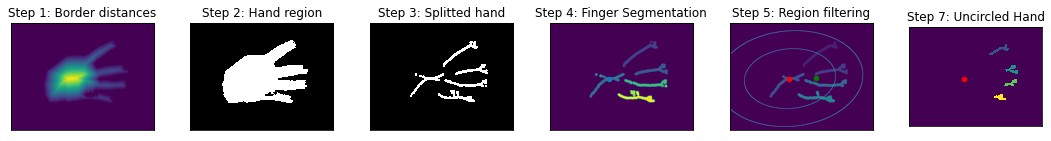

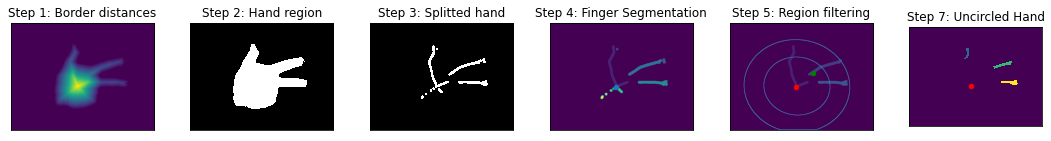

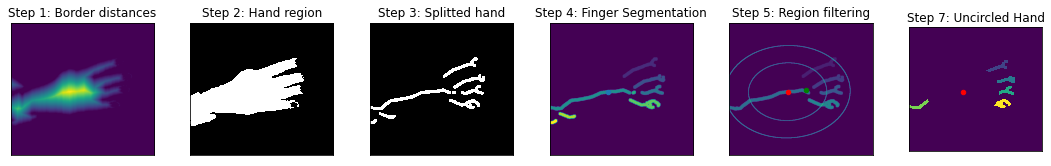

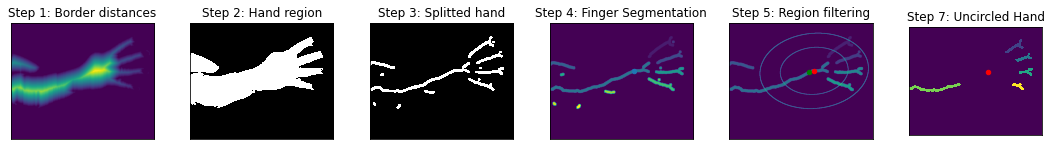

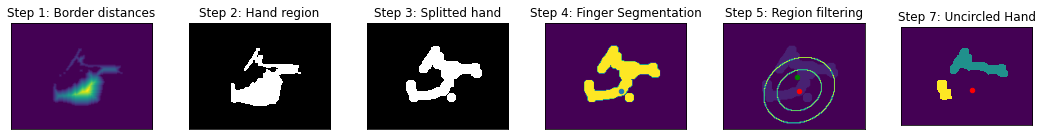

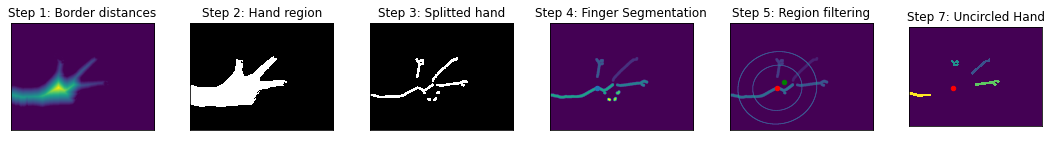

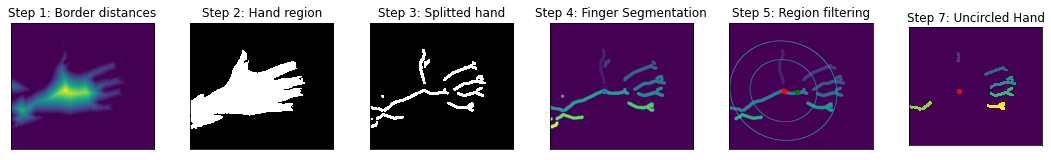

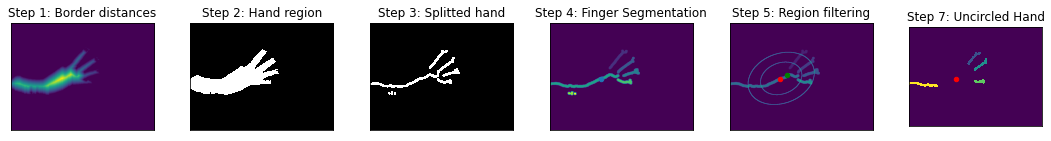

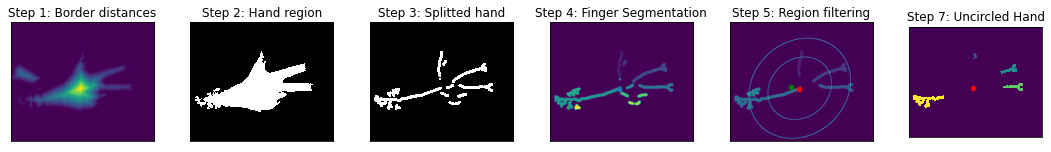

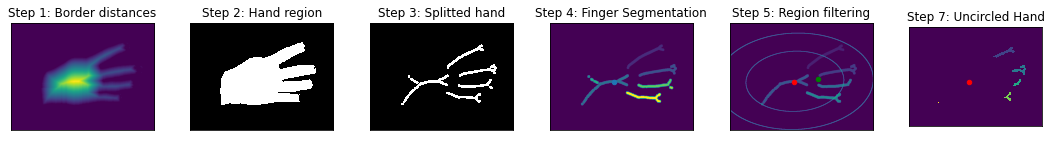

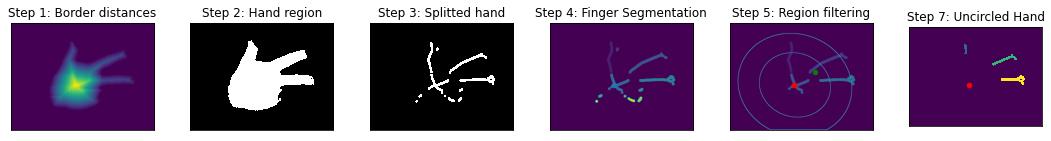

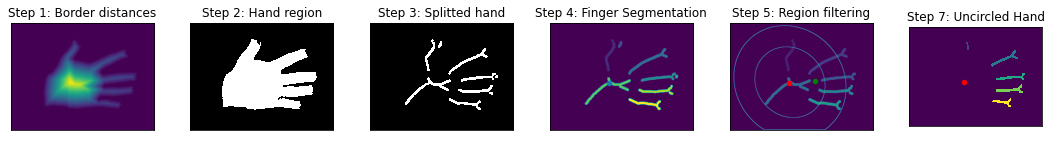

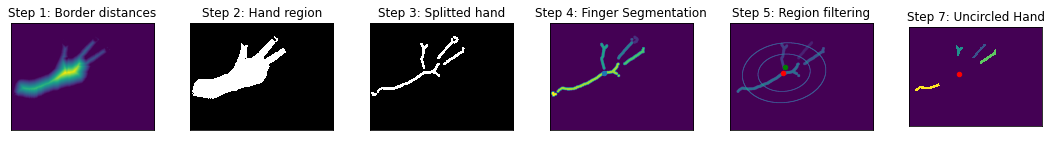

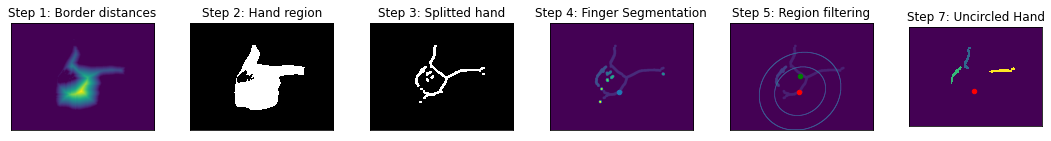

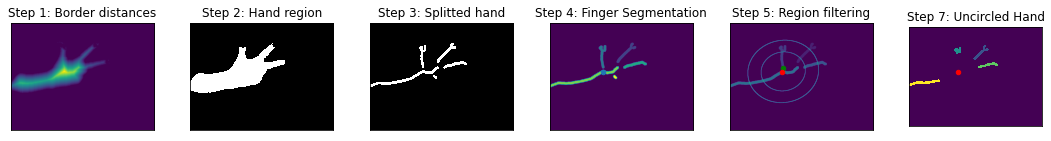

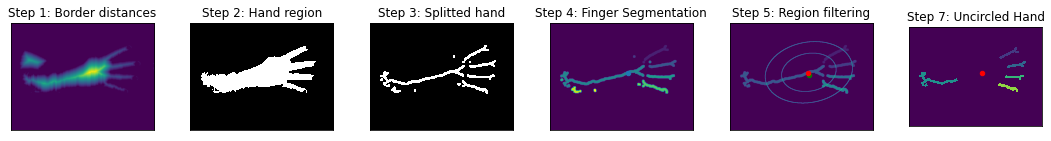

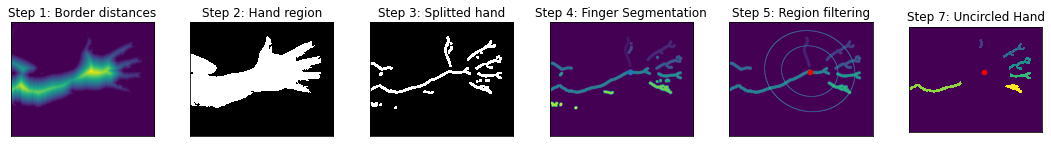

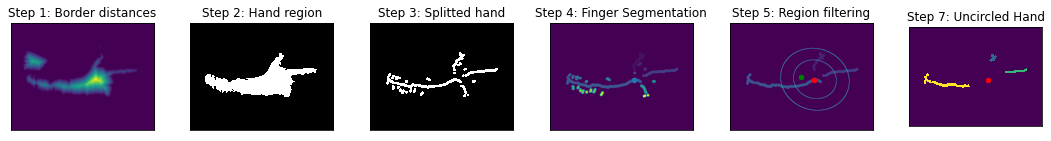

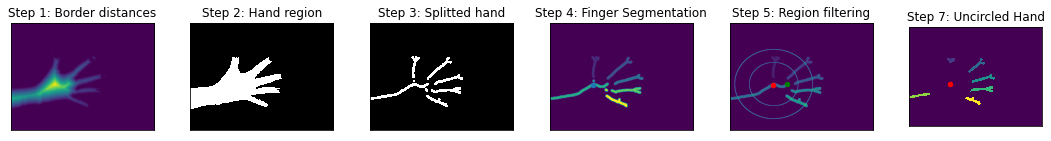

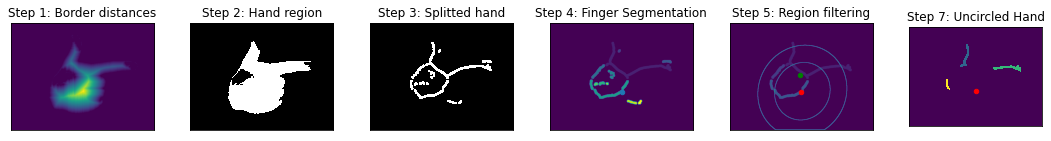

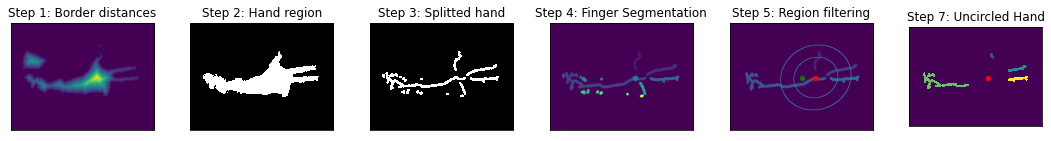

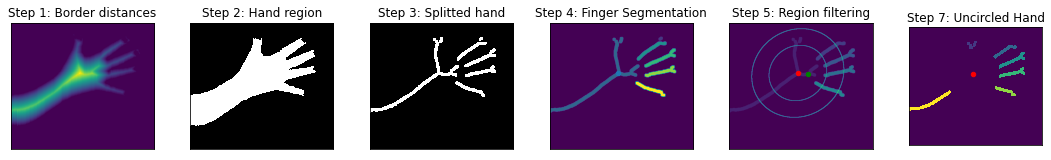

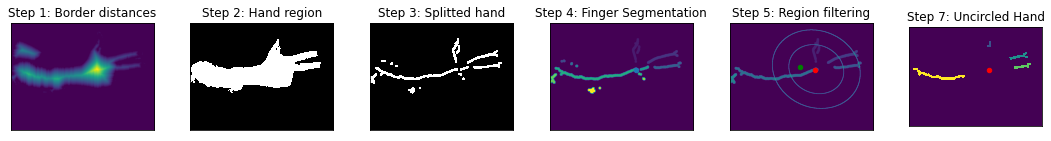

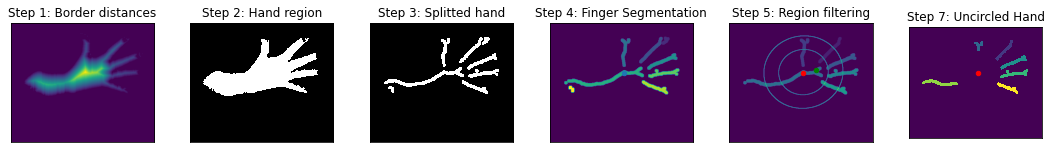

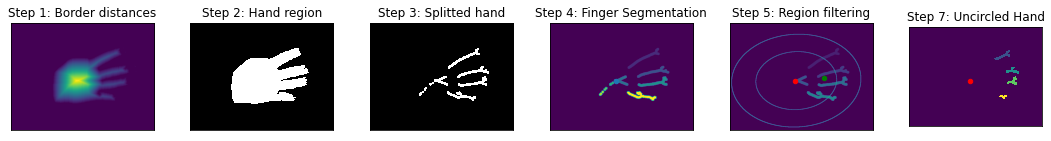

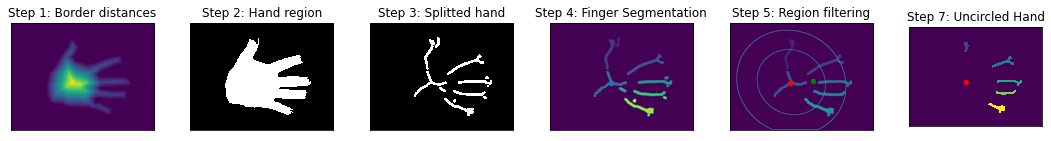

In [ ]:
# ALL validation
preds_val = predict_all(val_preds, levels_all_val, get_segmentation=False, show_steps=True, dilation_radius = Radius, min_filter_size=Filter, elipse_radius=Factor)

In [ ]:

s = np.maximum(np.ones(len(validation_fingers)), (np.array(preds_val)-1))
np.sum(s == validation_fingers)/len(validation_fingers), f1_fingers(np.array(validation_fingers), s.astype(int))

(0.6521739130434783, 0.6543137254901961)

In [ ]:
no_arm = np.array([3, 7, 11, 14, 16, 17, 20, 21, 24, 29, 30, 31, 33, 39, 44, 45])
a = np.ones(len(validation_fingers))
a[no_arm] = 0
s = np.maximum(np.ones(len(validation_fingers)), (np.array(preds_val)-a))
np.sum(s == validation_fingers)/len(validation_fingers), f1_fingers(np.array(validation_fingers), s.astype(int))

(0.8043478260869565, 0.8020772946859903)

### Hyperparameter optimization

The following cell was modified to obtained the different combinations. We used pickle to store results since it took a long time.

In [ ]:
# Cell hyperparameter
import pickle as pkl

show_steps=False

radius = np.array([5,7]).astype(int)
filter_sizes = np.arange(4, 9, 1).astype(int)
rad_factors = np.arange(1.2, 1.3, 0.01)

combinations = []
accuracies = []
f1_scores = []

filt = [4, 10, 13, 16, 22, 24, 27, 28, 59]
valid = np.ones(len(train_preds)).astype(bool)
valid[filt] = False
train_filt = train_preds[valid]
levels_all_filt = np.array(levels_all)[valid]
targets_filt = np.array(train_fingers)[valid]

for rad in radius:
    for fsize in filter_sizes:
        for rfact in rad_factors:
            preds = predict_all(train_filt, levels_all_filt, get_segmentation=False, show_steps=show_steps, dilation_radius = rad, min_filter_size=fsize, elipse_radius=rfact)
            combinations.append((rad, fsize, rfact))
            predsnou = np.array(preds)-1

            acc = np.sum(predsnou == targets_filt)/len(train_filt)
            accuracies.append(acc)
            
            f1 = f1_fingers(predsnou, targets_filt)
            f1_scores.append(f1)
            print(f'Radius = {rad:.2f}, Filter = {fsize:.2f}, Factor = {rfact:.2f}, Acc = {acc:.3f}, F1 = {f1:.3f}')
    with open('/content/drive/My Drive/Finger detection/Hyperparams/'+str(rad)+'.p', 'wb') as f:
        pkl.dump([combinations, accuracies, f1_scores], f)

Radius = 5.00, Filter = 4.00, Factor = 1.20, Acc = 0.627, F1 = 0.626
Radius = 5.00, Filter = 4.00, Factor = 1.21, Acc = 0.569, F1 = 0.579
Radius = 5.00, Filter = 4.00, Factor = 1.22, Acc = 0.569, F1 = 0.580
Radius = 5.00, Filter = 4.00, Factor = 1.23, Acc = 0.608, F1 = 0.618
Radius = 5.00, Filter = 4.00, Factor = 1.24, Acc = 0.647, F1 = 0.650
Radius = 5.00, Filter = 4.00, Factor = 1.25, Acc = 0.667, F1 = 0.667
Radius = 5.00, Filter = 4.00, Factor = 1.26, Acc = 0.647, F1 = 0.656
Radius = 5.00, Filter = 4.00, Factor = 1.27, Acc = 0.686, F1 = 0.680
Radius = 5.00, Filter = 4.00, Factor = 1.28, Acc = 0.667, F1 = 0.665
Radius = 5.00, Filter = 4.00, Factor = 1.29, Acc = 0.686, F1 = 0.684
Radius = 5.00, Filter = 4.00, Factor = 1.30, Acc = 0.686, F1 = 0.684
Radius = 5.00, Filter = 5.00, Factor = 1.20, Acc = 0.667, F1 = 0.667
Radius = 5.00, Filter = 5.00, Factor = 1.21, Acc = 0.647, F1 = 0.656
Radius = 5.00, Filter = 5.00, Factor = 1.22, Acc = 0.647, F1 = 0.656
Radius = 5.00, Filter = 5.00, Fact